# Warm up
 
The provided dataset (stocks.csv) contains information about a stock market, with opening,
closing, the highest and the lowest price with its volume for each day. Follow these steps:

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

**1. Read the csv file correctly!**

In [2]:
spark = SparkSession.builder \
    .appName("example") \
    .getOrCreate()

stocks_df = spark.read.csv('stocks.csv', header=True, inferSchema=True)
stocks_df.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|
+----------+------------------+------------------+------------------+------------------+---------+------------------+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|
|2010-01-11|212.79999700000002|        213.000002|      

**2. Find out about the schema of data**

In [40]:
stocks_df.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Adj Close: double (nullable = true)



**3. For those records with closing price less than 500, select opening, closing and volume and show them.**

In [44]:
filtered_df1 = stocks_df.filter(stocks_df['Close'] < 500).select('Open', 'Close', 'Volume')
filtered_df1.show()

+------------------+------------------+---------+
|              Open|             Close|   Volume|
+------------------+------------------+---------+
|        213.429998|        214.009998|123432400|
|        214.599998|        214.379993|150476200|
|        214.379993|        210.969995|138040000|
|            211.75|            210.58|119282800|
|        210.299994|211.98000499999998|111902700|
|212.79999700000002|210.11000299999998|115557400|
|209.18999499999998|        207.720001|148614900|
|        207.870005|        210.650002|151473000|
|210.11000299999998|            209.43|108223500|
|210.92999500000002|            205.93|148516900|
|        208.330002|        215.039995|182501900|
|        214.910006|            211.73|153038200|
|        212.079994|        208.069996|152038600|
|206.78000600000001|            197.75|220441900|
|202.51000200000001|        203.070002|266424900|
|205.95000100000001|        205.940001|466777500|
|        206.849995|        207.880005|430642100|


**4. Find out records with opening price more than 200 and closing price less than 200.**

In [45]:
filtered_df2 = stocks_df.filter((stocks_df['Open'] > 200) & (stocks_df['Close'] < 200))
filtered_df2.show()

+----------+------------------+----------+----------+----------+---------+------------------+
|      Date|              Open|      High|       Low|     Close|   Volume|         Adj Close|
+----------+------------------+----------+----------+----------+---------+------------------+
|2010-01-22|206.78000600000001|207.499996|    197.16|    197.75|220441900|         25.620401|
|2010-01-28|        204.930004|205.500004|198.699995|199.289995|293375600|25.819922000000002|
|2010-01-29|        201.079996|202.199995|190.250002|192.060003|311488100|         24.883208|
+----------+------------------+----------+----------+----------+---------+------------------+



**5. Extract the year from the date and save it in a new column**

In [60]:
stocks_df = stocks_df.withColumn('Year', substring_index(col('Date'), '-', 1))
stocks_df.show()

+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|      Date|              Open|              High|               Low|             Close|   Volume|         Adj Close|Year|
+----------+------------------+------------------+------------------+------------------+---------+------------------+----+
|2010-01-04|        213.429998|        214.499996|212.38000099999996|        214.009998|123432400|         27.727039|2010|
|2010-01-05|        214.599998|        215.589994|        213.249994|        214.379993|150476200|27.774976000000002|2010|
|2010-01-06|        214.379993|            215.23|        210.750004|        210.969995|138040000|27.333178000000004|2010|
|2010-01-07|            211.75|        212.000006|        209.050005|            210.58|119282800|          27.28265|2010|
|2010-01-08|        210.299994|        212.000006|209.06000500000002|211.98000499999998|111902700|         27.464034|2010|
|2010-01-11|212.

**6. Now, for each year, show the minimum volumes traded, shown in a column named ‘minVolume’.**

In [61]:
df_min_volume = stocks_df.groupBy('Year').agg(min('volume').alias('minVolume'))
df_min_volume.show()

+----+---------+
|Year|minVolume|
+----+---------+
|2016| 11475900|
|2012| 43938300|
|2014| 14479600|
|2013| 41888700|
|2011| 44915500|
|2015| 13046400|
|2010| 39373600|
+----+---------+



**7. Follow quite the same procedure as the previous step, but now for each year and month, show the highest low price, shown in a column named ‘maxLow’.**

In [67]:
stocks_df = stocks_df.withColumn('Month', split(col('Date'), '-')[1])
df_max_low_price = stocks_df.groupBy('Year', 'Month').agg(max('Low').alias('maxLow'))
df_max_low_price.show()

+----+-----+------------------+
|Year|Month|            maxLow|
+----+-----+------------------+
|2015|   09|        115.440002|
|2016|   05|             99.25|
|2012|   11|        594.170021|
|2014|   11|        118.050003|
|2014|   12|        115.290001|
|2015|   11|        121.620003|
|2013|   04|        432.069996|
|2014|   03| 539.5899730000001|
|2010|   02|        202.000004|
|2014|   09|        102.720001|
|2010|   01|        213.249994|
|2010|   05|        262.880009|
|2016|   04|111.33000200000001|
|2010|   09|        291.009998|
|2013|   05|        455.810005|
|2015|   07|        130.699997|
|2015|   05|        131.399994|
|2010|   03|        234.459999|
|2012|   12|        585.500023|
|2016|   07|            103.68|
+----+-----+------------------+
only showing top 20 rows



**8. For the last step, calculate mean and standard deviation of high price over the whole data frame and show them in two decimal places.**

In [68]:
mean_std_df = stocks_df.select(mean('High').alias('meanHigh'), stddev('High').alias('stddevHigh'))
mean_std_df.select(format_number('meanHigh', 2).alias('meanHigh'),
                   format_number('stddevHigh', 2).alias('stddevHigh')).show()

+--------+----------+
|meanHigh|stddevHigh|
+--------+----------+
|  315.91|    186.90|
+--------+----------+



# Preprocess Main Task

The provided dataset(spotify.parquet) contains information about songs streamed on
Spotify, which is an audio streaming and media service provider.

In [3]:
spark = SparkSession.builder \
    .appName("Spotify Dataset Analysis") \
    .getOrCreate()

spotify_df = spark.read.parquet("spotify.parquet")

spotify_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



In [4]:
spotify_df.sample(False, 0.1, 444).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+----------------+------------------+------------------+------------------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|      acousticness|instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+--

We will get the summary of our data frame, mostly to see the range of our data, the mean and median, and how many are null.

In [8]:
#summary_df = spotify_df.summary()
#
#summary_df.show()

We can see that only a few song names and albums are null, and the rest aren't null. We can also see that the min value for years and release date is 0 which isn't correct. We can either drop these columns, try to estimate them using the mean, median, or mode, or we can do some form of regression. For null names and albums we can see if the ids are repeated elsewhere as all columns have ids and replace them with the corresponding id.

### Preprocessing

First we'll fix the null values and 0 values for date

In [6]:
from pyspark.sql.functions import col, sum as spark_sum, when

def count_null_values(df):
    null_counts = df.select([spark_sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in df.columns])
    return null_counts

In [7]:
result = count_null_values(spotify_df)
result.show()

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|  0|   0|    0|       0|      0|         0|           0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|   0|           0|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

Here we check for null values

In [8]:
from pyspark.sql import functions as F

def count_none_names(df, name_column):
    none_names = df.filter(F.col(name_column).isNull())
    none_names.show()
    print("Number of rows where the name column is None: ", none_names.count())

In [9]:
count_none_names(spotify_df , 'name')

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+

Number of rows where the name column is None:  0


In [10]:
count_none_names(spotify_df , 'album')

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+

Number of rows where the name column is None:  0


After checking the null songs, we came to the conclusion that the names of these songs or albums were None, which were incorrectly saved as null after entering the system, which we will correct all of them.

In [11]:
spotify_df = spotify_df.fillna("None")

result = count_null_values(spotify_df)
result.show()

+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|  0|   0|    0|       0|      0|         0|           0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|   0|           0|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

In [12]:
def Count_unique(column):
    unique_id_count = spotify_df.select(column).distinct().count()
    print(f"Number of unique {column}:", unique_id_count)

In [13]:
Count_unique("id")
Count_unique("artists")
Count_unique("artist_ids")

Number of unique id: 1204025
Number of unique artists: 165365
Number of unique artist_ids: 166423


We can see that the number of 'id' is exactly as number of rows in the dataset .So we can drop it Because it is acting like index.

In [13]:
spotify_df = spotify_df.drop("id")

For release_date we changed every string form to yyyy-MM-DD form and create column year and day and month

In [15]:
from pyspark.sql.functions import col, to_date, year, dayofmonth
spotify_df = spotify_df.withColumn("release_date_formated", to_date(col("release_date"), "yyyy-MM-dd"))

In [16]:
from pyspark.sql.functions import col, date_format

spotify_df = spotify_df.withColumn("release_month", month(spotify_df["release_date_formated"]))
spotify_df = spotify_df.withColumn("release_day", dayofmonth(spotify_df["release_date_formated"]))
spotify_df = spotify_df.withColumn("release_week", date_format(col("release_date"), "EEEE"))

In [17]:
mismatched_rows = spotify_df.filter(year(spotify_df["release_date"]) != spotify_df["year"])
print("Number of rows where release_year and year do not match:", mismatched_rows.count())

Number of rows where release_year and year do not match: 0


In [18]:
def show_null_release_date_rows():
    null_release_date_rows = spotify_df.filter(spotify_df["release_date_formated"].isNull())
    print(null_release_date_rows.count())
    null_release_date_rows.show()

In [19]:
show_null_release_date_rows()

131186
+--------------------+--------------------+------------------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+--------------------+------------------+------------------+-------+-----------+--------------+----+------------+---------------------+-------------+-----------+------------+
|                  id|                name|             album|            album_id|    artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|      acousticness|    instrumentalness|          liveness|           valence|  tempo|duration_ms|time_signature|year|release_date|release_date_formated|release_month|release_day|release_week|
+--------------------+--------------------+------------------+--------------------+-----------+--------------------+------------+-----------+--------

As you can see, after converting to the yyyy-mm-dd format, some lines became null, the reason being that the release_date was not in this format, and we store the corresponding day and month as zero.

In [19]:
from pyspark.sql.functions import lit

spotify_df = spotify_df.fillna({'release_month': 0, 'release_day': 0})
show_null_release_date_rows()

131186
+--------------------+------------------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+--------------------+------------------+------------------+-------+-----------+--------------+----+------------+---------------------+-------------+-----------+------------+
|                name|             album|            album_id|    artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|      acousticness|    instrumentalness|          liveness|           valence|  tempo|duration_ms|time_signature|year|release_date|release_date_formated|release_month|release_day|release_week|
+--------------------+------------------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+

In [20]:
spotify_df = spotify_df.withColumn("duration_minutes", round(col("duration_ms") / 60000))

We converted "artists, album, name" columns to lower case

In [21]:
string_columns = ["artists", "album", "name"]
for col_name in string_columns:
    spotify_df = spotify_df.withColumn(col_name, lower(trim(col(col_name))))

Convert explicit col to numerical variable (true = 1, false = 0).

In [22]:
spotify_df = spotify_df.withColumn("explicit", when(spotify_df["explicit"] == True, 1).otherwise(0))

### Aggregation, Transformation, Selection and Explosion for Insights

First, we identify all the numerical variables.

In [23]:
data_types = spotify_df.dtypes
numerical_columns = [column[0] for column in data_types if column[1] in ('double', 'float', 'long', 'short', 'byte', 'bigint', 'int')]
for column in numerical_columns:
    print(column)

track_number
disc_number
explicit
danceability
energy
key
loudness
mode
speechiness
acousticness
instrumentalness
liveness
valence
tempo
duration_ms
time_signature
year
release_month
release_day
duration_minutes


Now we will examine some variables.We define the eda function and apply it to all these variables.

In [26]:
def visualize_numeric_variable(df, variable, bins):
    numerical_columns = [variable]
    data = df.select(*numerical_columns).toPandas()

    fig, axes = plt.subplots(1, 3, figsize=(18, 4))

    ax = axes[0]
    ax.hist(data[variable], bins=bins, color='lightgreen', edgecolor='black')
    ax.set_title(variable.capitalize() + " Distribution", fontsize=14, fontweight='bold', color='blue')
    ax.set_xlabel(variable.capitalize(), fontsize=12)
    ax.set_ylabel("Frequency", fontsize=12)

    ax = axes[1]
    sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
    ax.set_title(variable.capitalize() + " Violin Plot", fontsize=14, fontweight='bold', color='blue')
    ax.set_xlabel(variable.capitalize(), fontsize=12)

    ax = axes[2]
    sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')
    ax.set_title(variable.capitalize() + " Box Plot", fontsize=14, fontweight='bold', color='blue')
    ax.set_xlabel(variable.capitalize(), fontsize=12)

    plt.tight_layout()
    plt.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


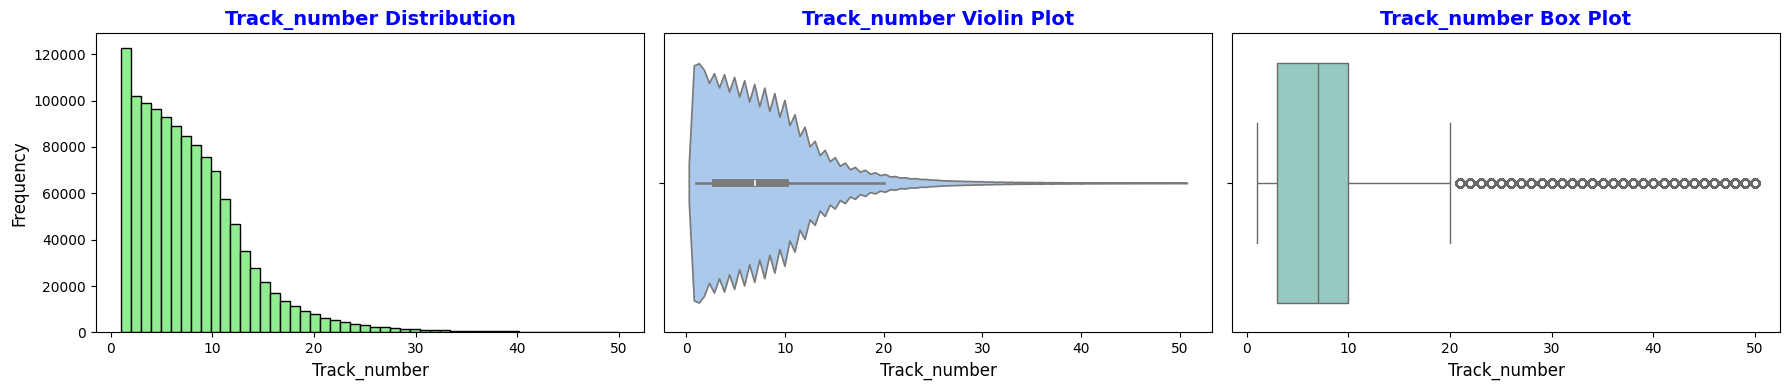

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


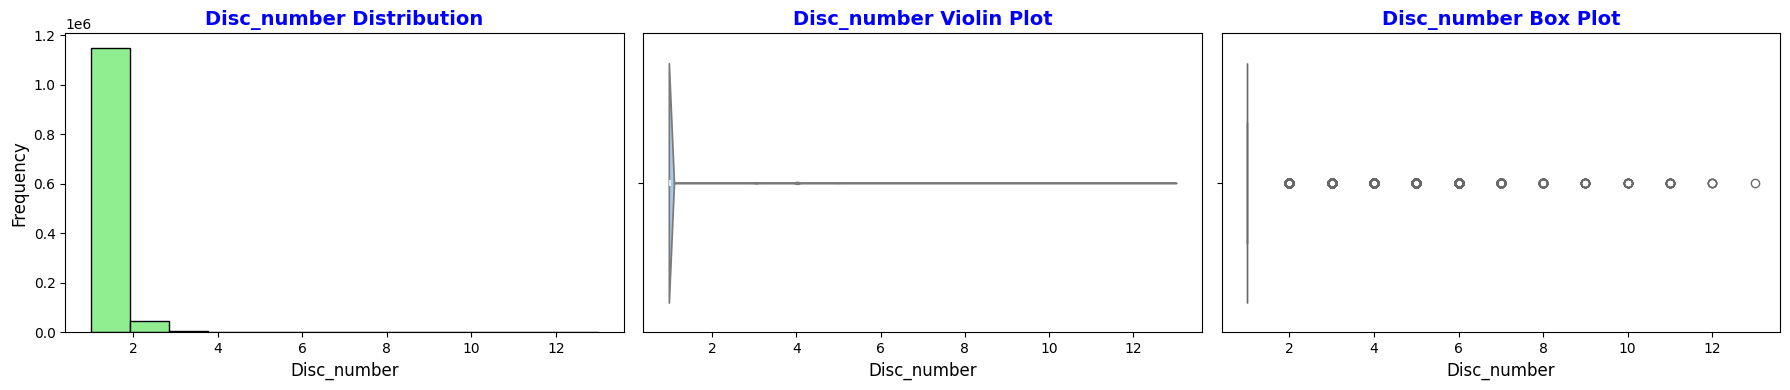

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


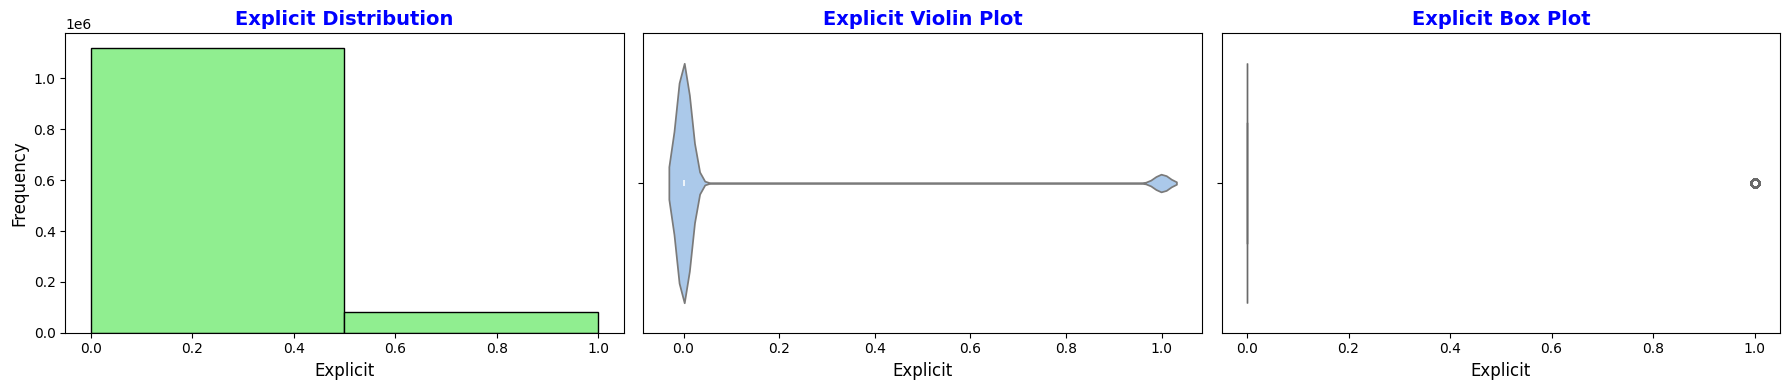

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


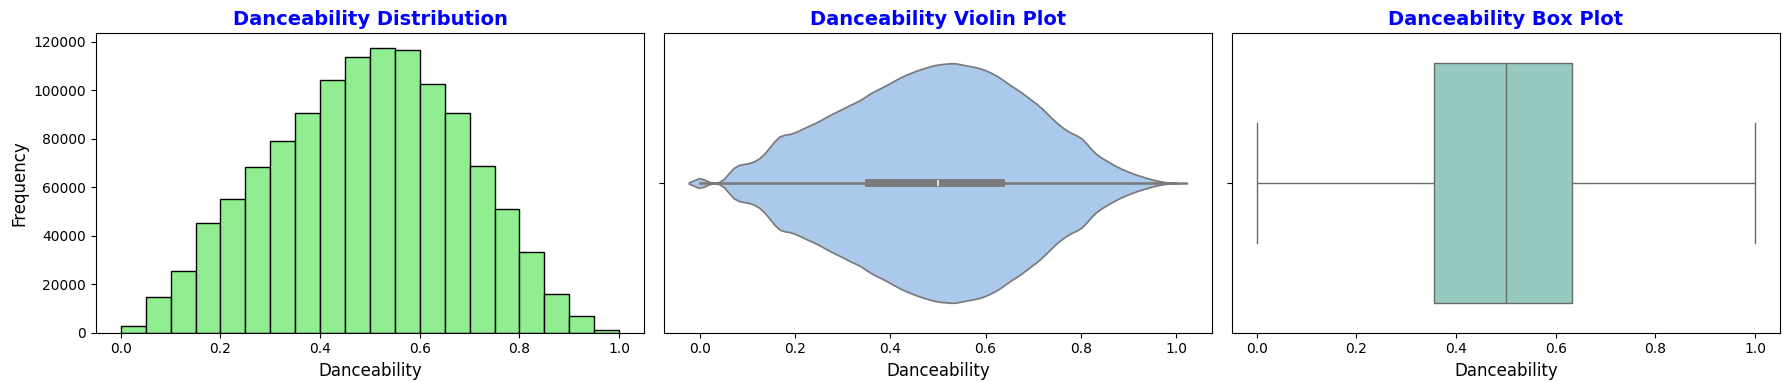

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


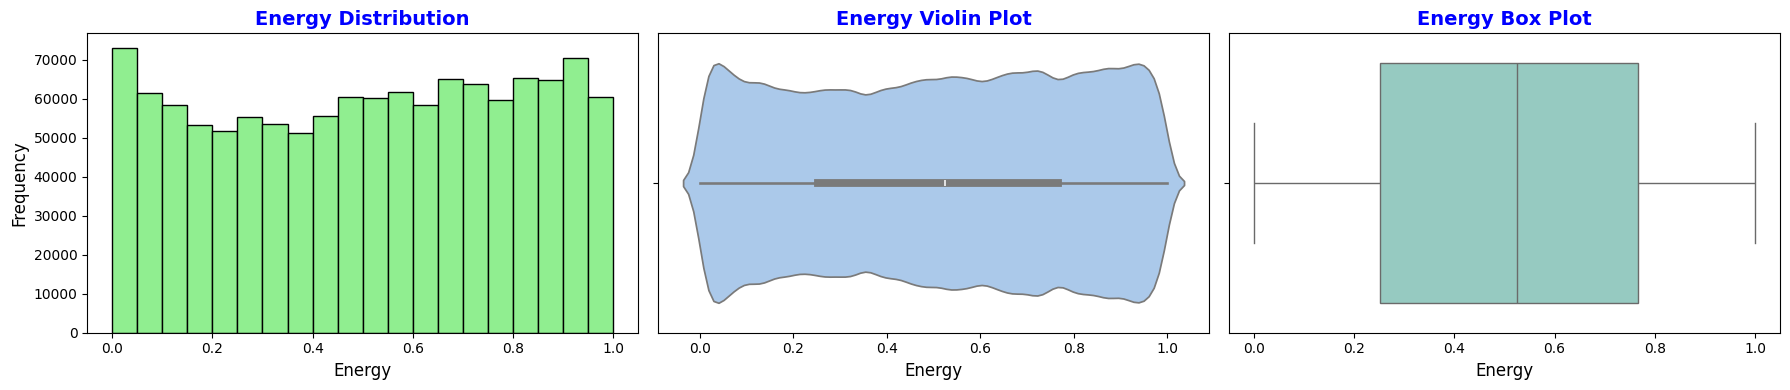

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


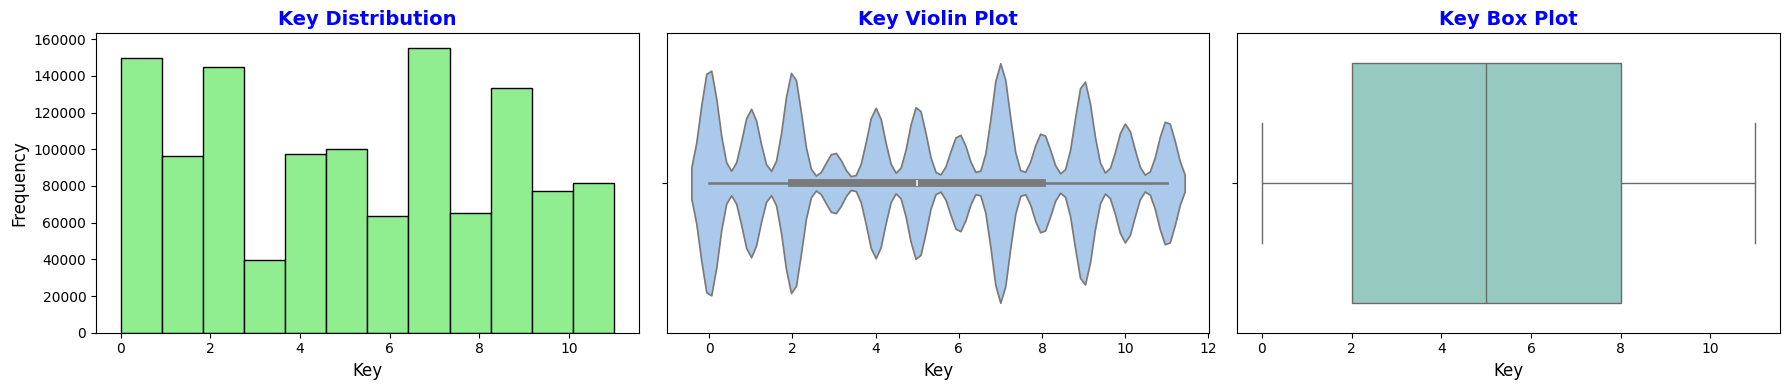

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


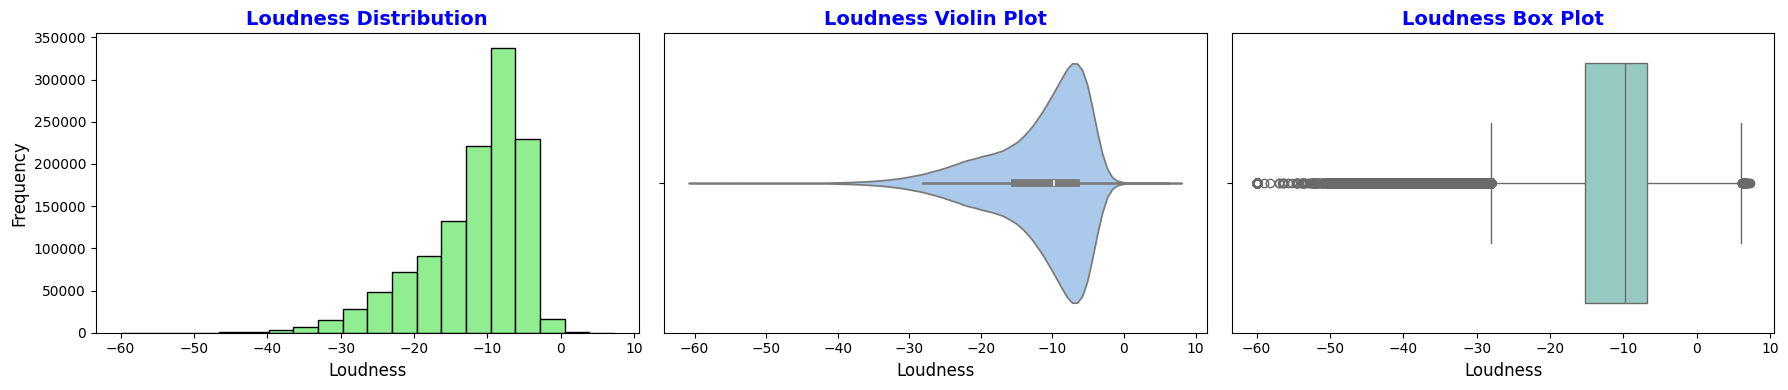

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


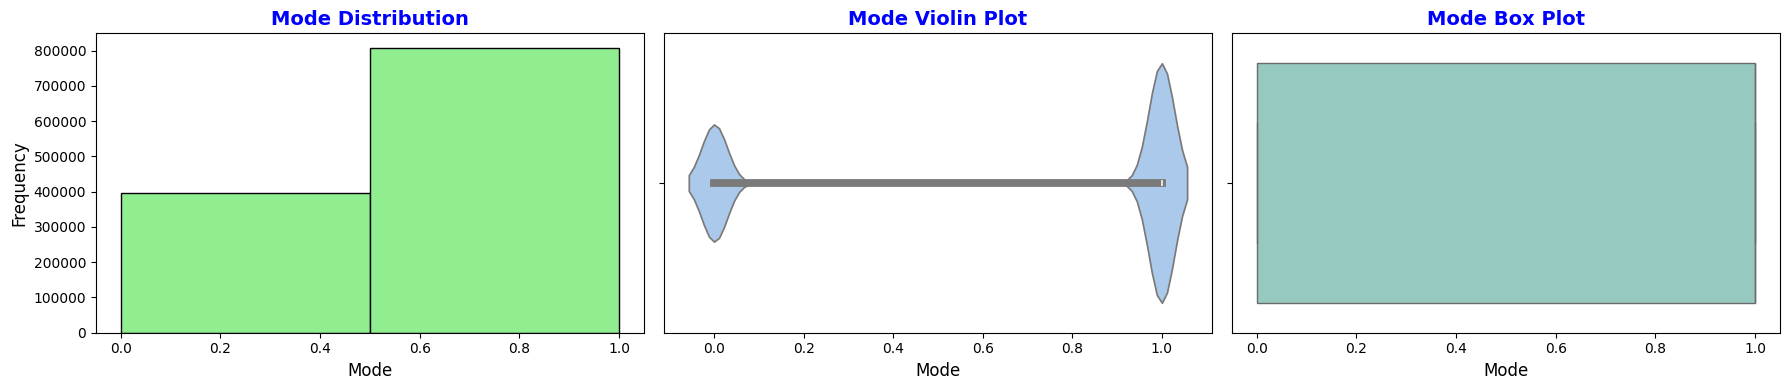

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


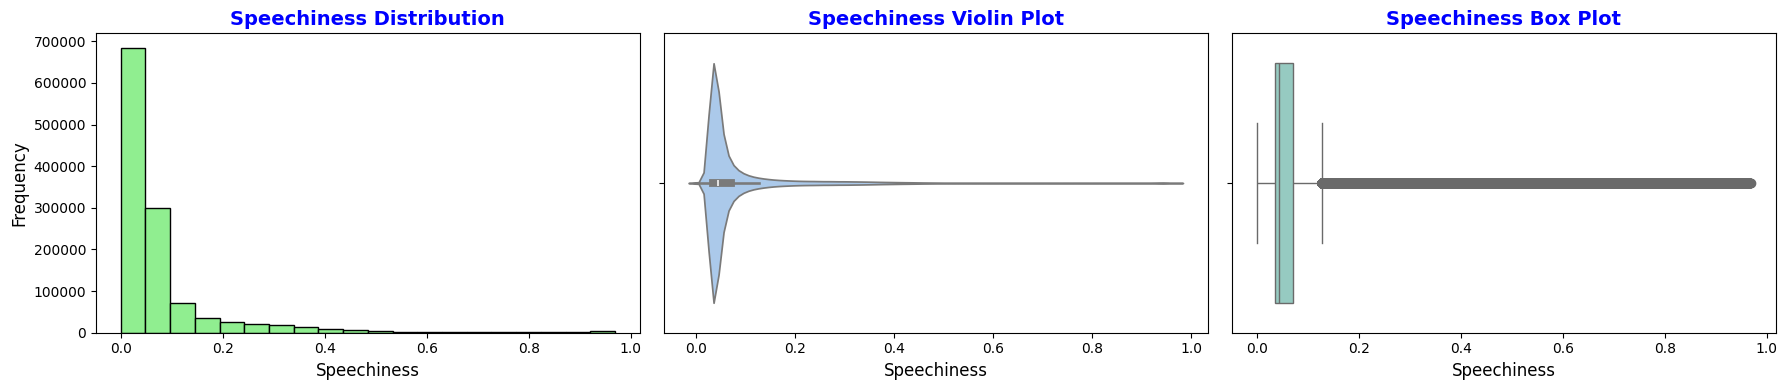

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


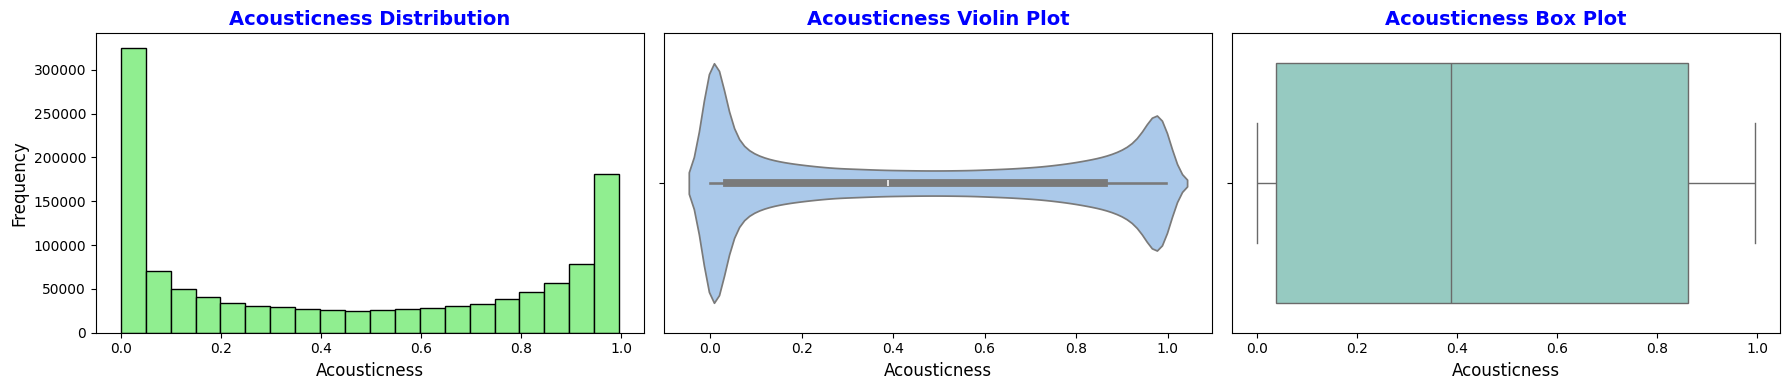

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


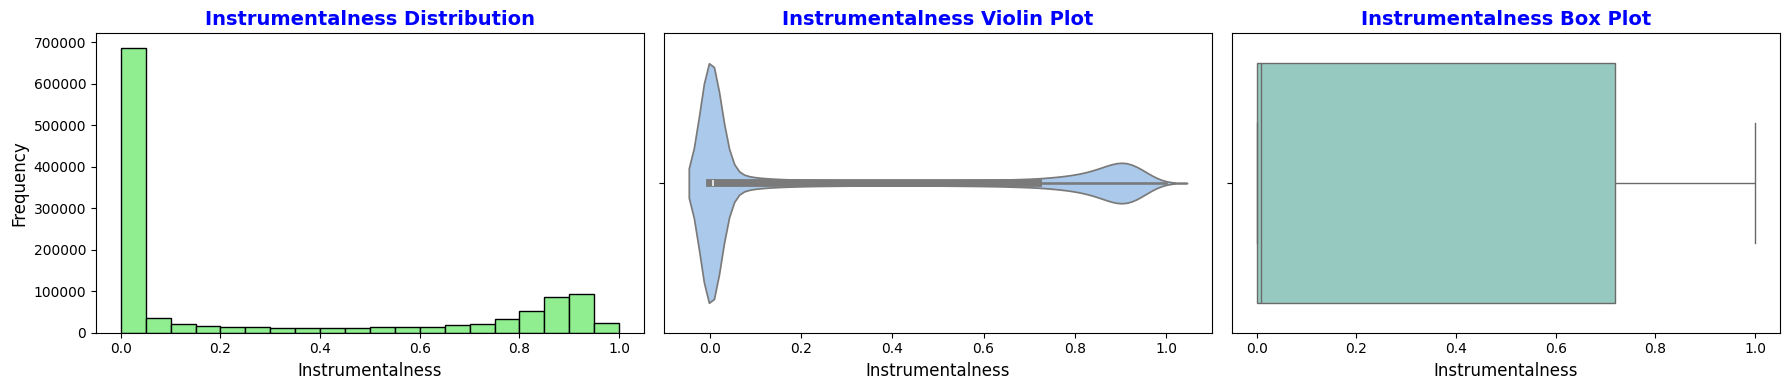

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


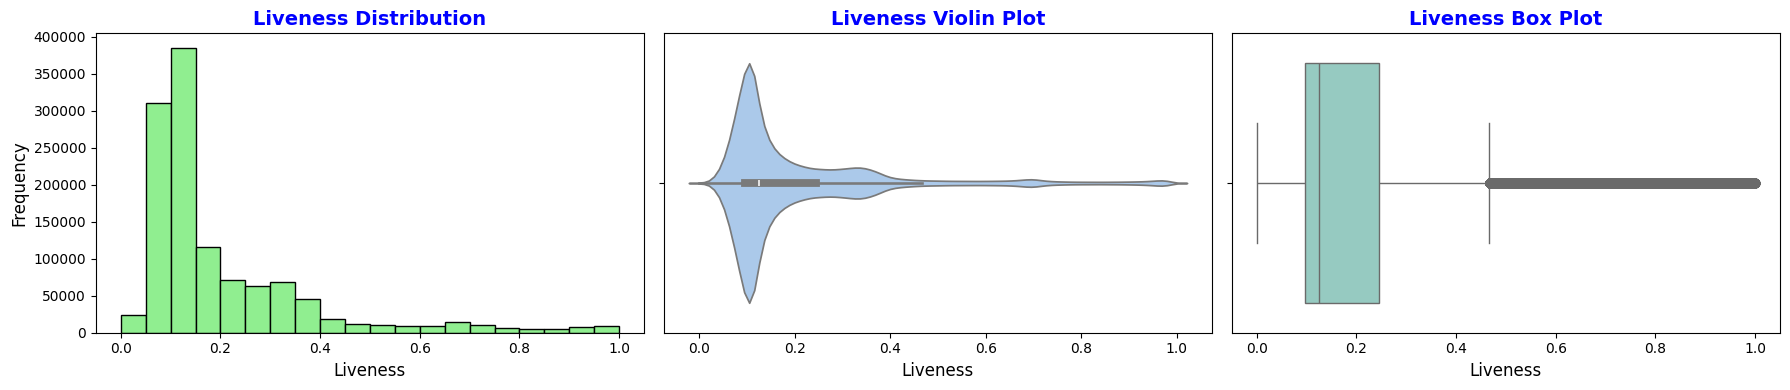

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


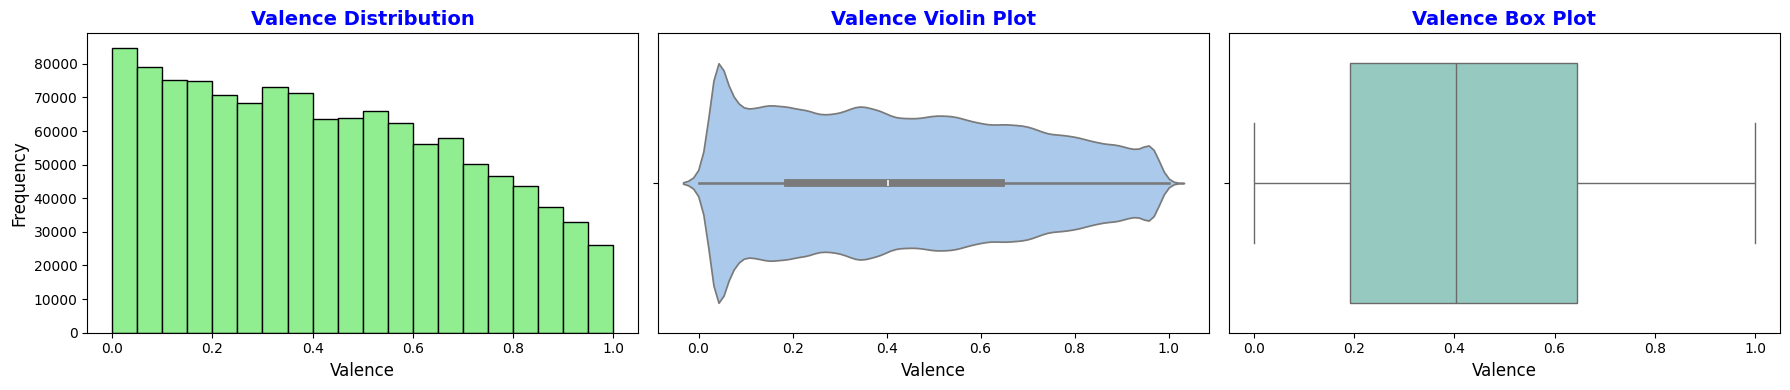

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


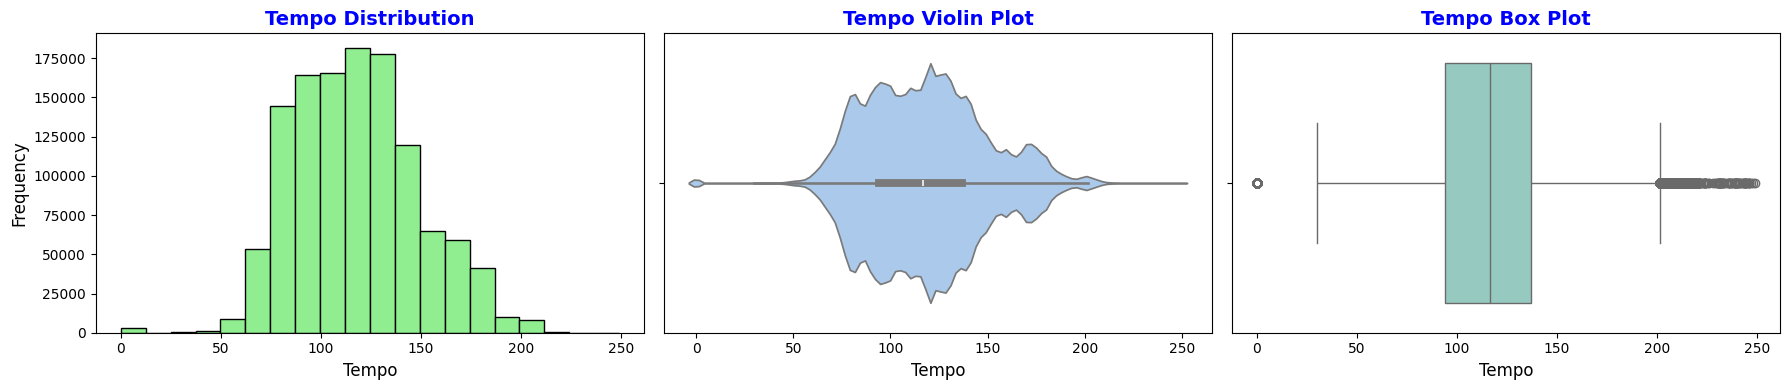

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


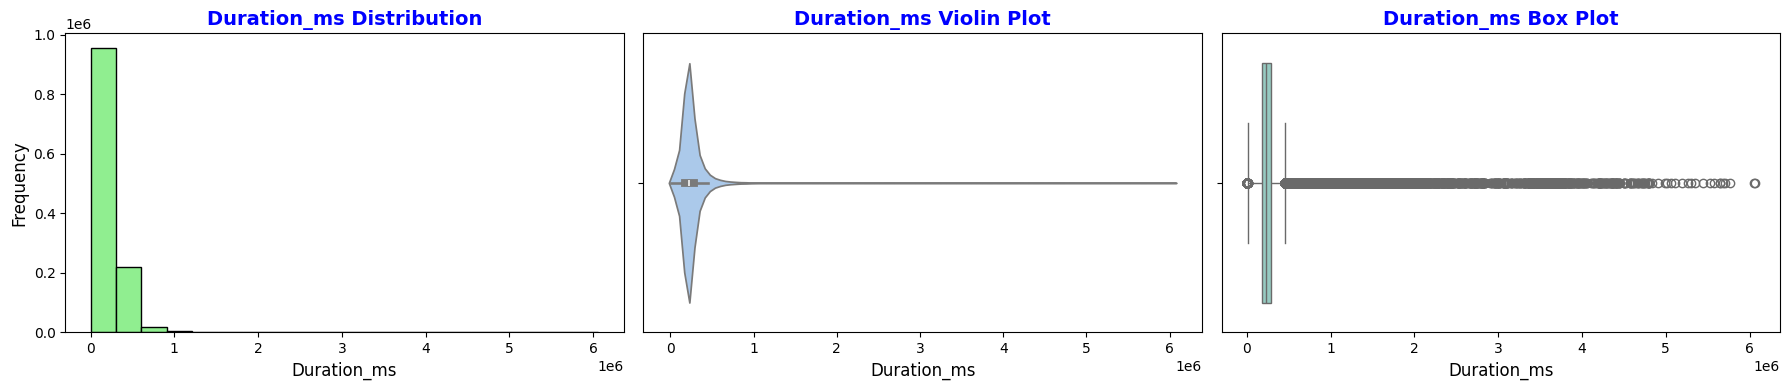

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


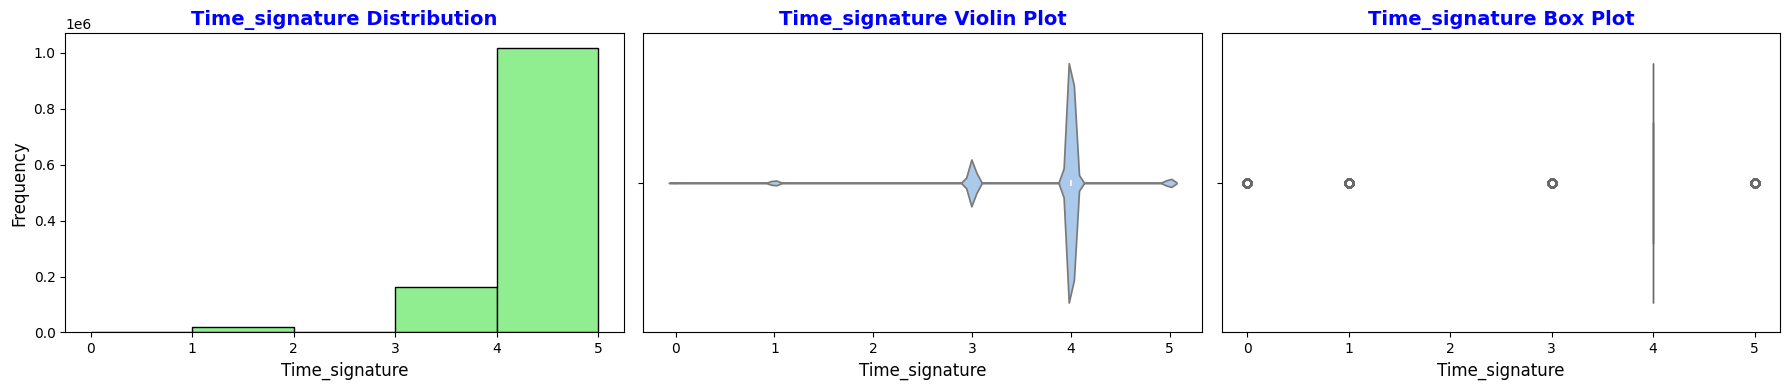

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


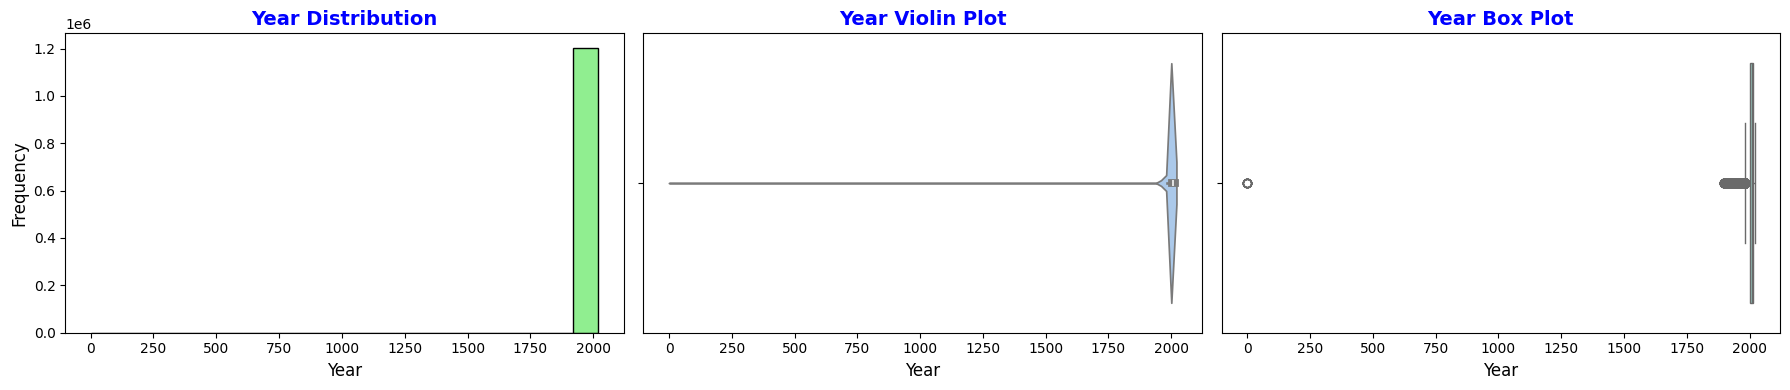

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


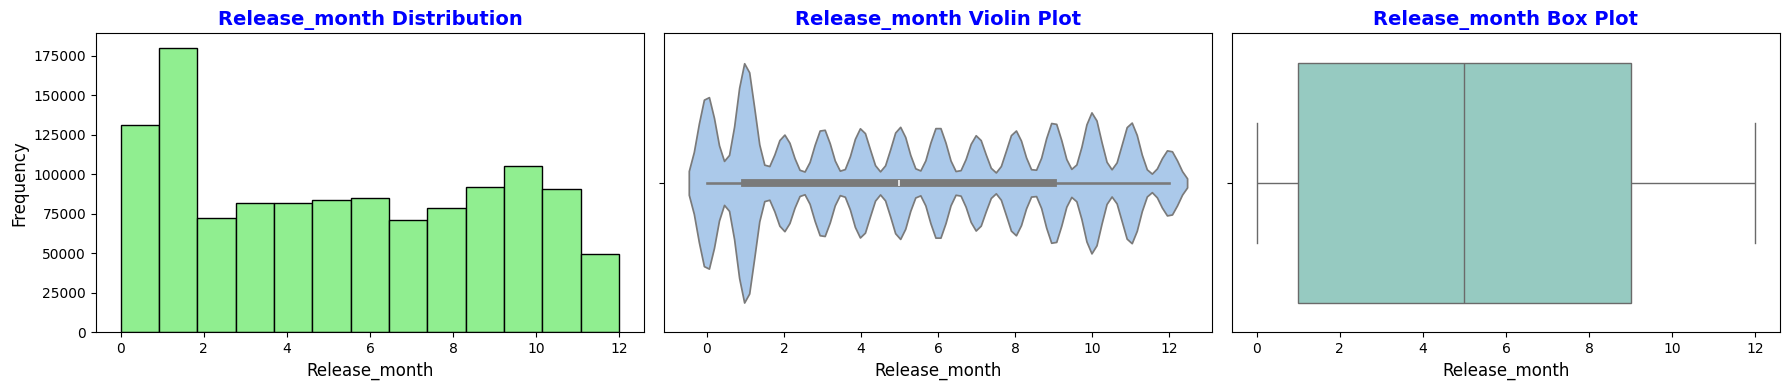

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


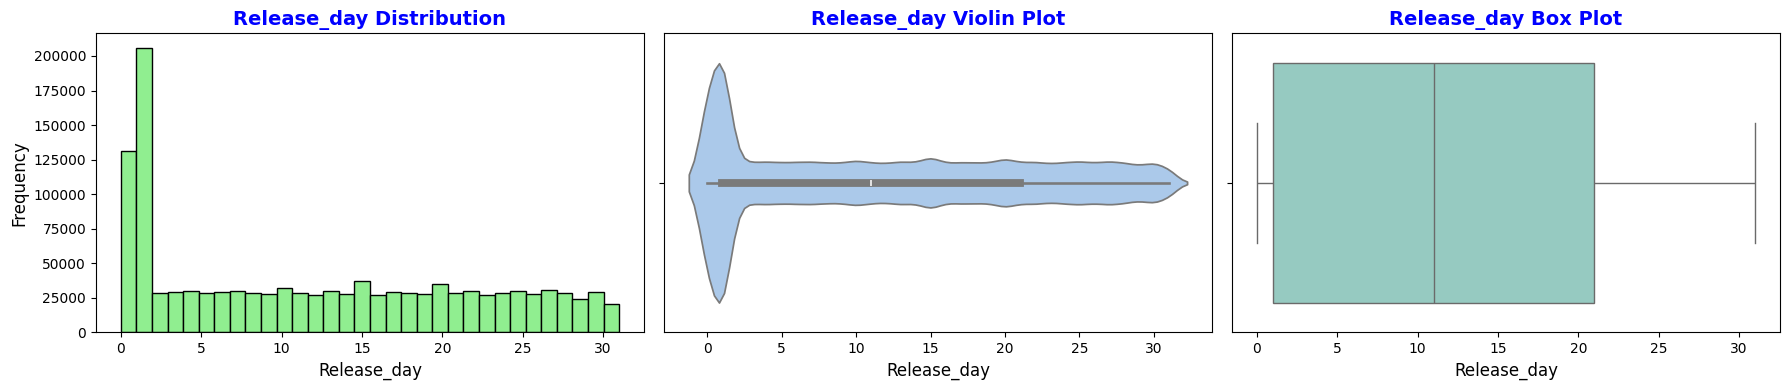

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


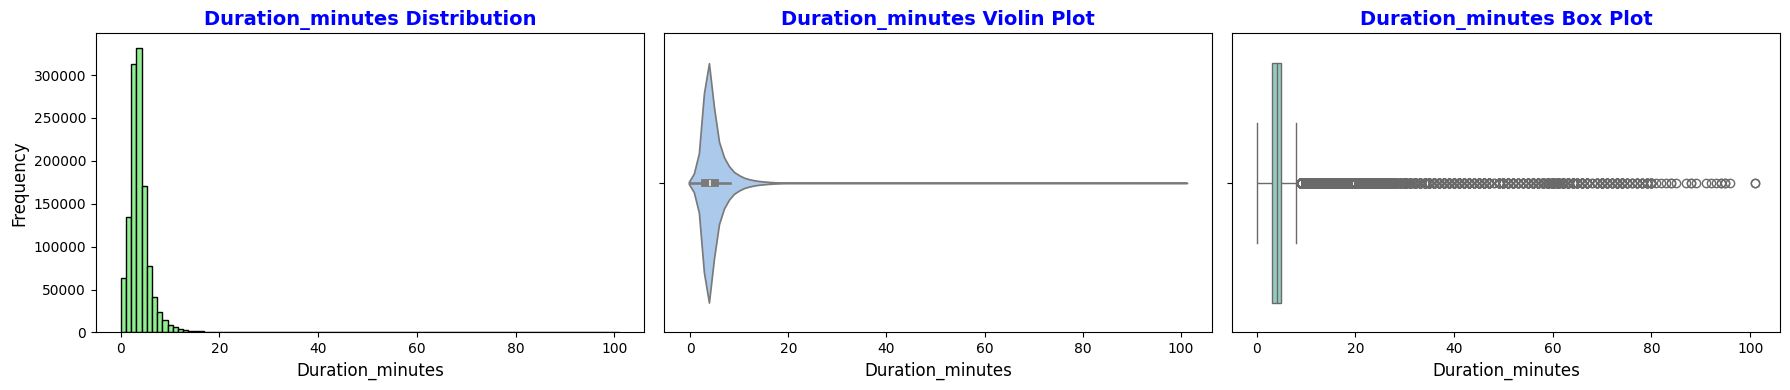

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4080\1437258195.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


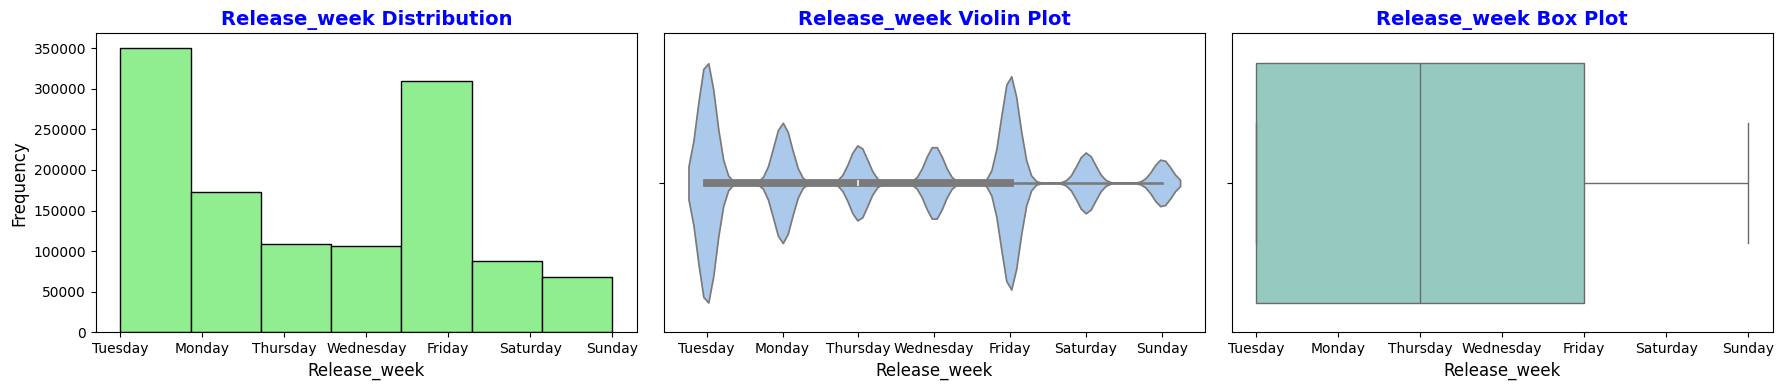

In [27]:
should_do_eda_variables = numerical_columns + ["release_week"]
for col in should_do_eda_variables:
    bin_size = spotify_df.select([col]).distinct().count()
    bin_size = 20 if bin_size > 100 else bin_size
    visualize_numeric_variable(spotify_df, col, bin_size)

- track_number: The right-skewed distribution suggests that albums or playlists tend to have more tracks assigned to lower track numbers. This skewness could arise from practices like reserving higher track numbers for bonus tracks, or artists intentionally structuring their albums with more impactful or popular songs towards the beginning.

- disc_number: The heavy skew towards lower values is expected, as most albums are single-disc releases. The distribution likely reflects the lower frequency of multi-disc albums in the dataset.

- danceability: The roughly normal distribution implies that songs span a broad range of danceability levels, catering to various preferences and genres. The central tendency could suggest that moderately danceable tracks are more common or preferred.

- energy: The approximately normal distribution indicates a balance between high and low energy tracks in the dataset. The slight skew towards higher energy levels could be attributed to the popularity of upbeat, energetic music for certain genres or listening contexts.

- key: The relatively uniform distribution across different key values suggests that key signatures are evenly represented in the dataset, with no particular key being overly favored or underrepresented.

- loudness: The normal distribution of loudness levels could stem from industry practices and guidelines for audio mastering and normalization, aiming to maintain a consistent listening experience across tracks and albums.

- mode: The higher frequency of major keys aligns with the general preference for major tonalities in popular music, as they are often perceived as more upbeat and positive.

- speechiness: The heavy right skew towards lower speechiness scores is expected, as most popular music tracks are primarily instrumental or contain minimal spoken content.

- acousticness: The slight skew towards lower acousticness values could reflect the prevalence of electronic and heavily produced music genres, which rely less on acoustic instrumentation.

- instrumentalness: The skew towards lower instrumentalness scores suggests that most tracks in the dataset contain vocals, which is common for mainstream popular music genres.

- liveness: The heavy right skew towards lower liveness scores aligns with the expectation that most commercially released music is studio-recorded rather than live recordings.

- valence: The roughly normal distribution with a slight skew towards higher valence scores could indicate a preference for more positive and uplifting musical tones in popular music.

- tempo: The normal tempo distribution suggests a balanced representation of various tempos in the dataset, catering to different musical genres and preferences.

- duration_ms: The right-skewed distribution towards shorter durations is likely due to the prevalence of radio-friendly song lengths and the commercial demand for concise, well-paced tracks.

- time_signature: The higher frequency of common time signatures like 4/4 is expected, as they are the most widely used meters in popular Western music genres.

- duration_minutes: The right-skewed distribution, mirroring that of duration_ms, reinforces the observation that shorter track lengths are more common in the dataset, potentially driven by commercial and listener preferences for concise songs.

- explicit: Most of the songs do not contain explicit, and if there are many of these cases, we should check them

- year: The distribution in this section and the skew to the left means that most of our data is for recent years, and for further investigation, we must remove outliers, i.e. less than 1990.

- release_month: With a general look, you can understand that the distribution between different months is almost the same, but it seems that the first two months are considered the best time to release a song.

- release_day: It seems that the first two days of the month have the highest amount of publication, and the distribution is almost the same for the rest of the month

- release_week: Our plots confirm the industry norm of releasing music primarily on Fridays (Global Release Day), with Mondays being a secondary preference. This trend likely stems from marketing strategies and listener engagement patterns, aimed at maximizing visibility and sales. It seems that the mainstream companies choose the end of the week to release, and the rest of the time to attract more attention, they release their songs with the biggest time difference from them in order to attract more attention.

#### check Outliers

In [28]:
from pyspark.sql.functions import col
import math

variables_should_eda_for_outliers = ["danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "explicit"]

def get_outliers_row(df, variable, show_rows=False):
    q1, q3 = df.approxQuantile(variable, [0.25, 0.75], 0.01)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    print(f'lower whisker: {lower_bound}, upper whisker: {upper_bound}')

    outliers = df.filter((col(variable) < lower_bound) | (col(variable) > upper_bound))
    
    print("Number of outliers:", outliers.count())
    if show_rows:
        outliers.select(variable).show()
        outliers.show()
    
    return outliers


def plot_variable_distribution(df):
    num_variables = len(variables_should_eda_for_outliers)
    num_rows = (num_variables + 4) // 5
    fig, axes = plt.subplots(num_rows, 5, figsize=(20, num_rows*4))

    for i, variable in enumerate(variables_should_eda_for_outliers):
        numerical_columns = [variable]
        data = df.select(numerical_columns).toPandas()

        row_index = i // 5
        col_index = i % 5

        ax = axes[row_index, col_index]
        sns.histplot(data[variable], bins='auto', kde=True, color='skyblue', ax=ax)
        sns.kdeplot(data=data, x=variable, color='darkorange', ax=ax)
        sns.boxplot(data=data, y=variable, color='lightgreen', ax=ax, width=0.3)
        
        ax.set_title(variable.capitalize() + " Distribution")
        ax.set_xlabel(variable.capitalize())
        ax.set_ylabel("Density / Frequency")
        
    for i in range(num_variables, num_rows*5):
        row_index = i // 5
        col_index = i % 5
        fig.delaxes(axes[row_index, col_index])

    plt.tight_layout()
    plt.show()



Here we examine the outliers of the variables

In [36]:
variable = 'speechiness'
speechiness_outliers = get_outliers_row(spotify_df, variable)

lower whisker: -0.020550000000000006, upper whisker: 0.12785000000000002
Number of outliers: 168581


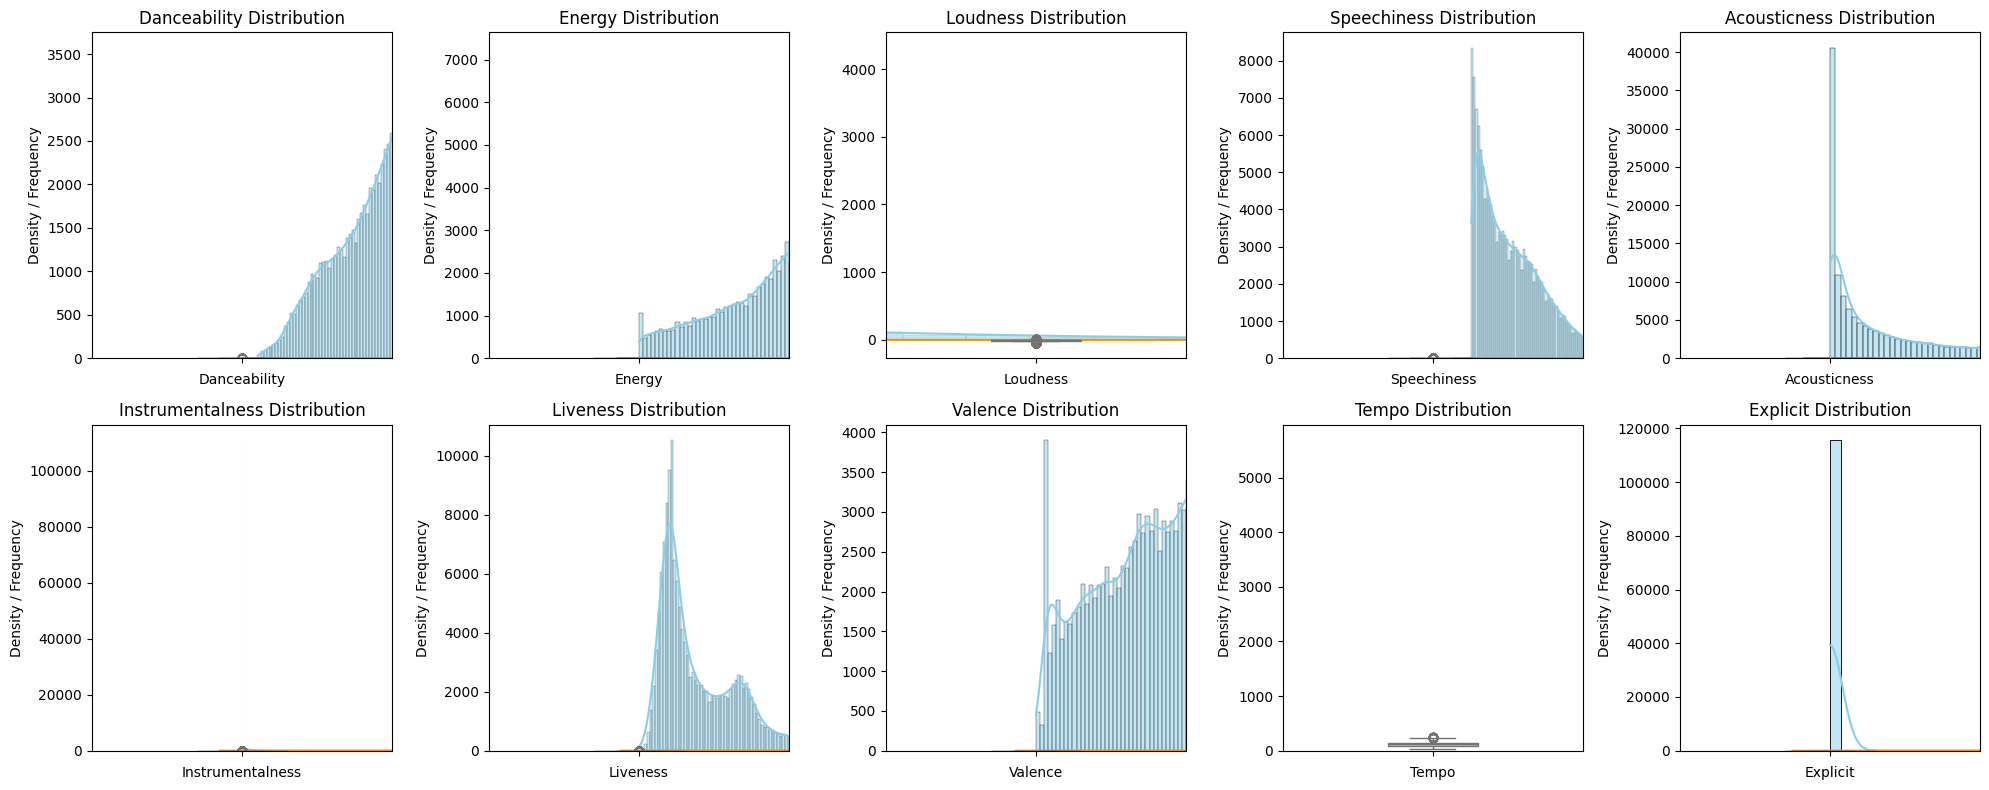

In [42]:
plot_variable_distribution(speechiness_outliers)

It can be seen that in the speechiness_outliers, which were all above the high whisker, the energy is more than the original distribution, and valence and tempo are skewed to the left instead of to the right. Also, acousticness has a more severe skew to the right.
Also, the level of explicitness has also increased compared to the rest of the data, which is logical. Probably the songs that are mostly rap are placed here and these songs use more vulgar words.

In [43]:
variable = 'liveness'
liveness_outliers = get_outliers_row(spotify_df, variable)

lower whisker: -0.121, upper whisker: 0.4598
Number of outliers: 97927


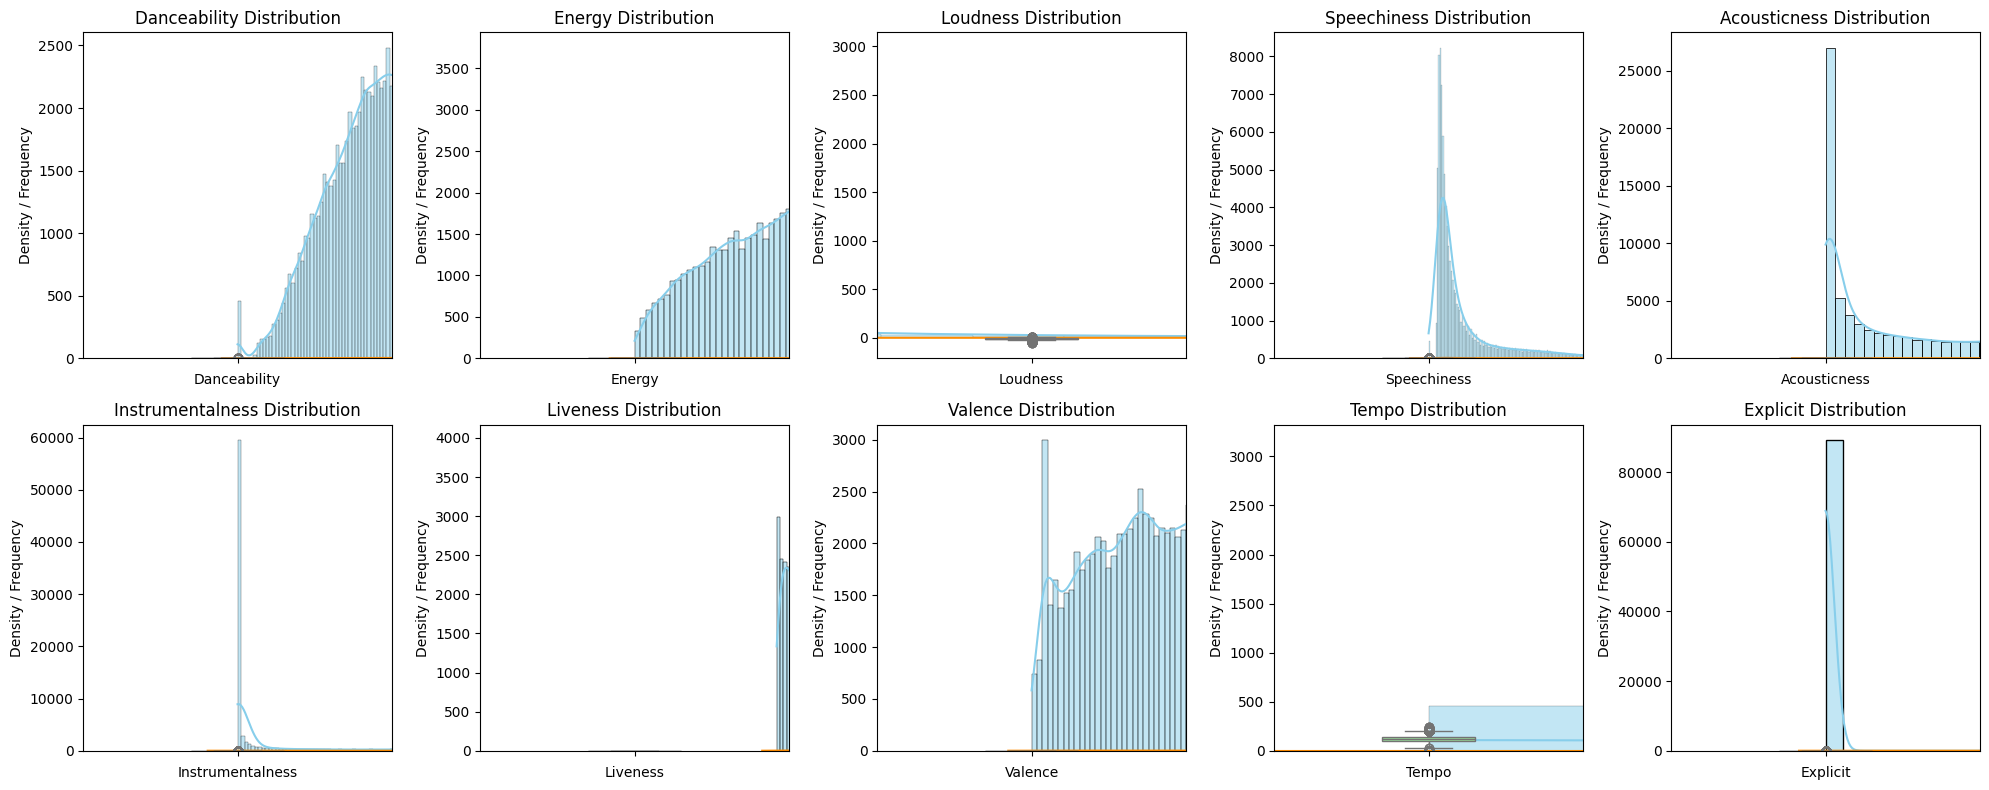

In [44]:
plot_variable_distribution(liveness_outliers)

We can only say that the energy has increased and we have a bias to the right.

In [46]:
variable = 'year'
year_outliers = get_outliers_row(spotify_df, variable, show_rows=True)

lower whisker: 1985.0, upper whisker: 2033.0
Number of outliers: 41131
+----+
|year|
+----+
|1984|
|1984|
|1984|
|1984|
|1984|
|1984|
|1984|
|1984|
|1984|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
|1973|
+----+
only showing top 20 rows

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+--------+----+-----------+------------------+----------------+------------------+------------------+-------+-----------+--------------+----+------------+---------------------+-------------+-----------+------------+----------------+
|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|loudness|mode|speechiness|      acousticness|instrumentalness|          liveness|           valence|  tempo|duration_ms|time_signature|year

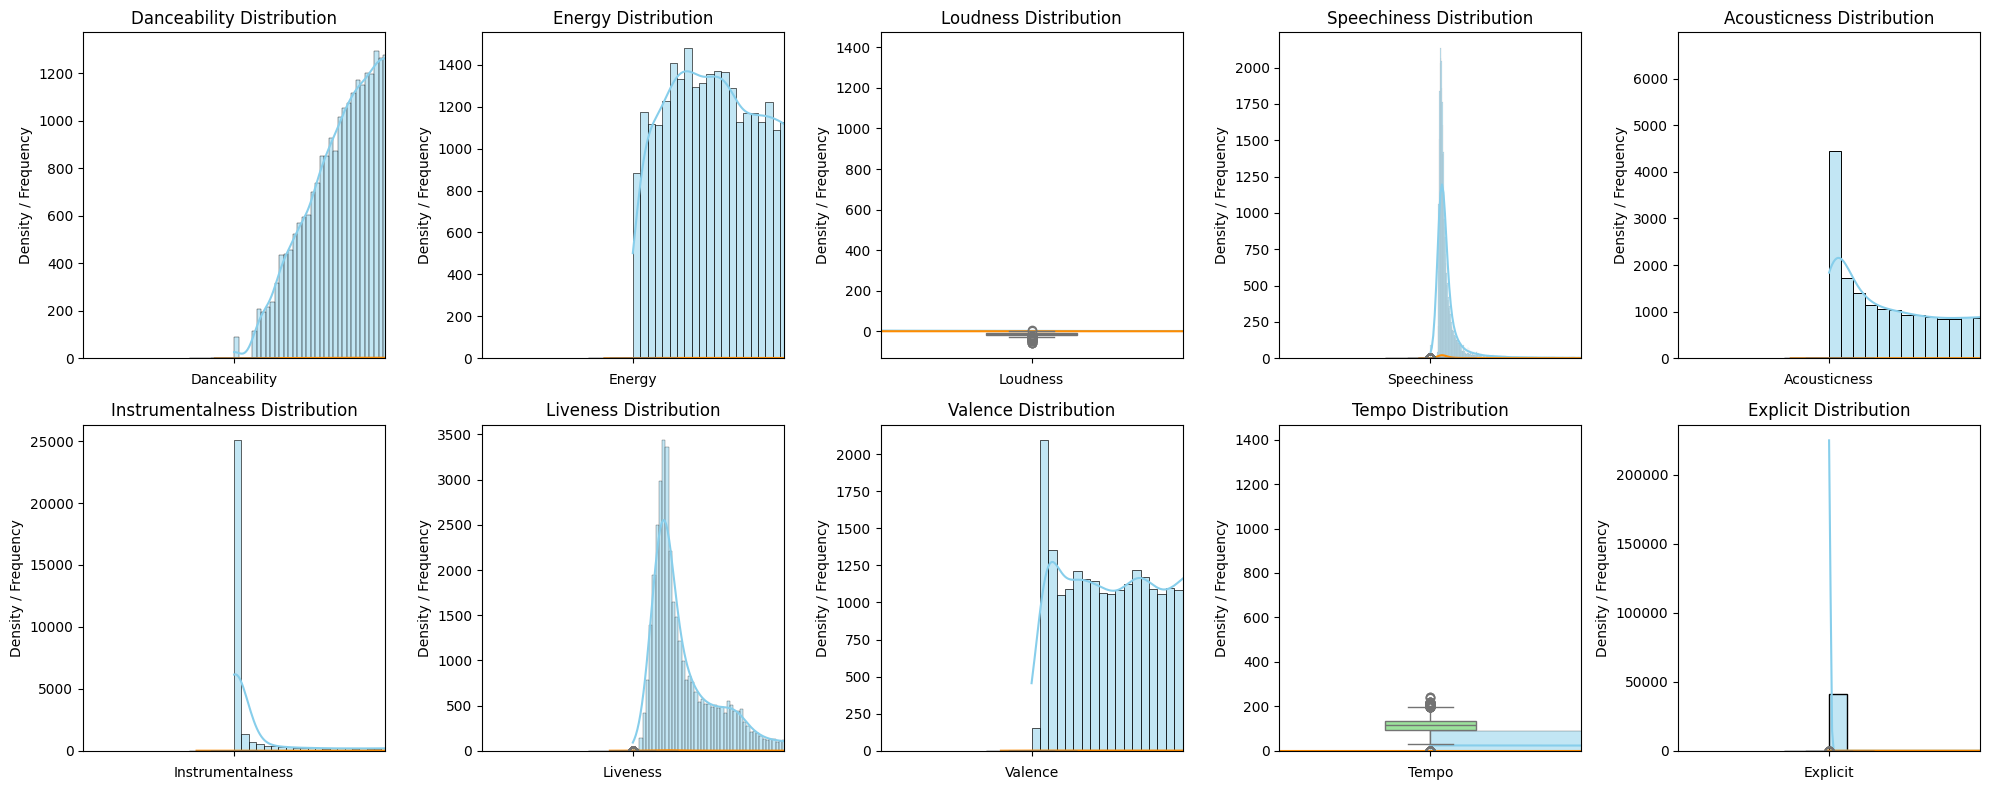

In [47]:
plot_variable_distribution(year_outliers)

In this section, year_outliers, all our outliers are related to the past years and less than 1985. Energy is skewed to the right. Also, the acousticness is more skewed to the left and it is the opposite of the whole data, which can be because of the time period we are examining it and in the past the songs had less acousticness.
Also, the amount of explicitness here is almost zero, which shows that vulgar words are rarely used in old songs.

In [49]:
variable = 'duration_minutes'
duration_minutes_outliers = get_outliers_row(spotify_df, variable, show_rows=True)

lower whisker: 0.0, upper whisker: 8.0
Number of outliers: 47020
+----------------+
|duration_minutes|
+----------------+
|             9.0|
|            11.0|
|            11.0|
|            13.0|
|             9.0|
|             9.0|
|            11.0|
|             9.0|
|             9.0|
|            13.0|
|            10.0|
|            13.0|
|            15.0|
|            11.0|
|            11.0|
|            11.0|
|            41.0|
|             9.0|
|            10.0|
|            13.0|
+----------------+
only showing top 20 rows

+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+------------------+------------------+------------------+------------------+-----------+--------------+----+------------+---------------------+-------------+-----------+------------+----------------+
|              

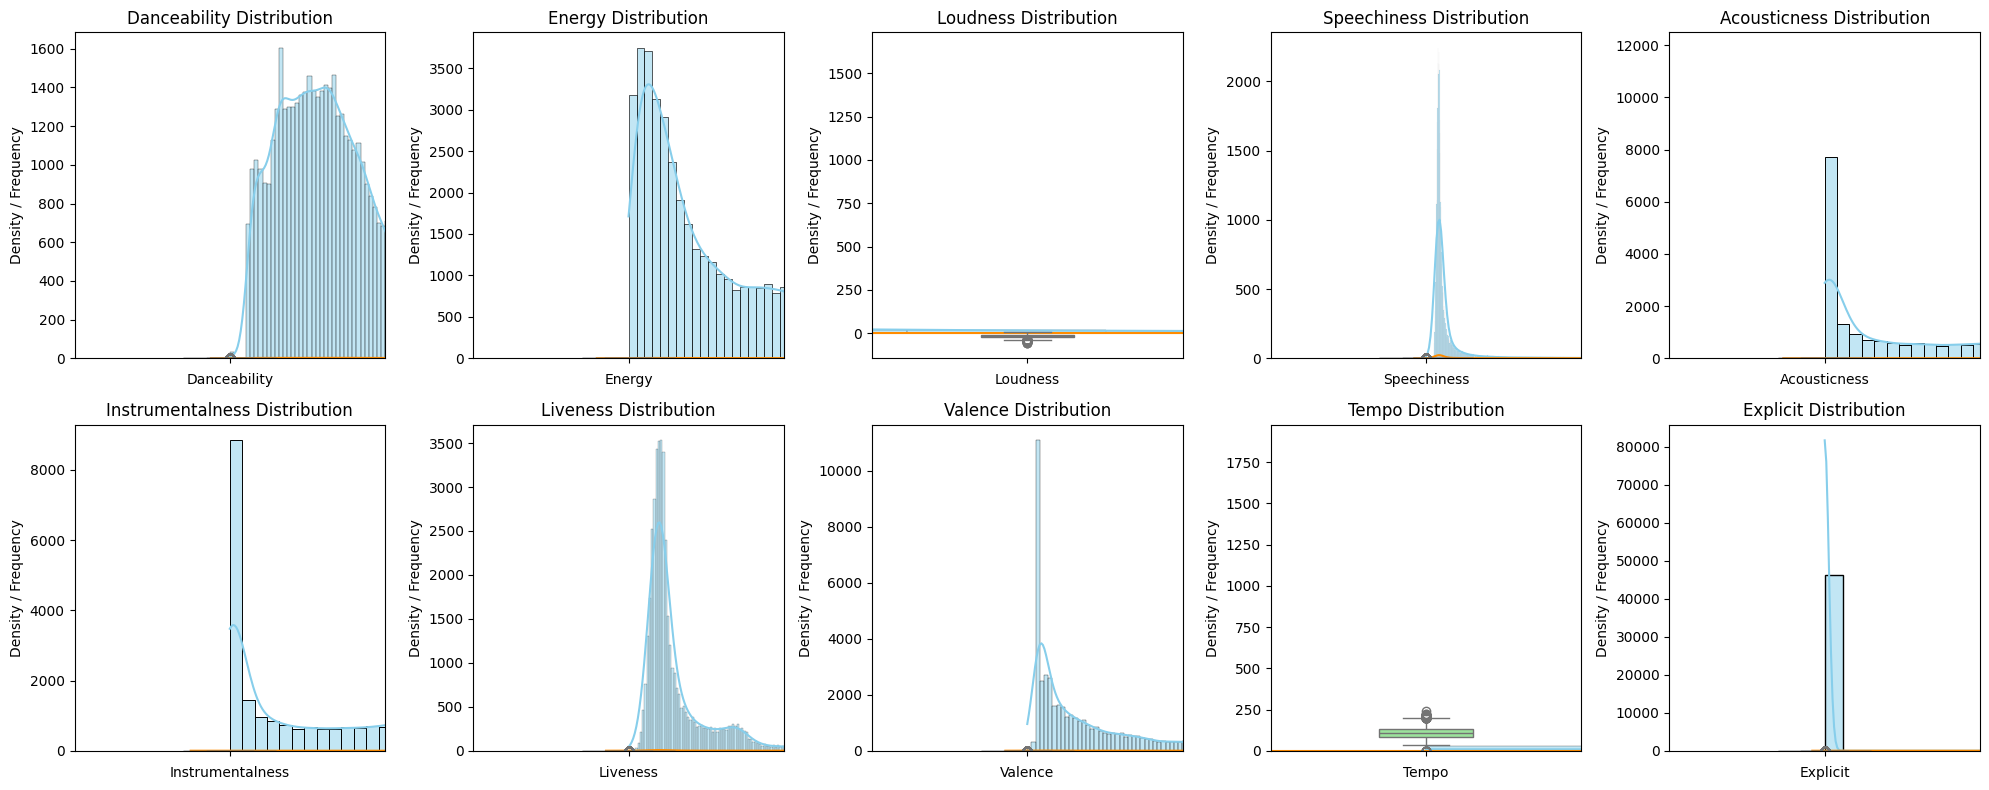

In [50]:
plot_variable_distribution(duration_minutes_outliers)

we wil remove outlier data from year and duration_minutes

In [29]:
spotify_df = spotify_df.filter(spotify_df["year"] >= 1900)
spotify_df = spotify_df.filter(spotify_df["duration_minutes"] <= 8)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10424\2224348992.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10424\2224348992.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


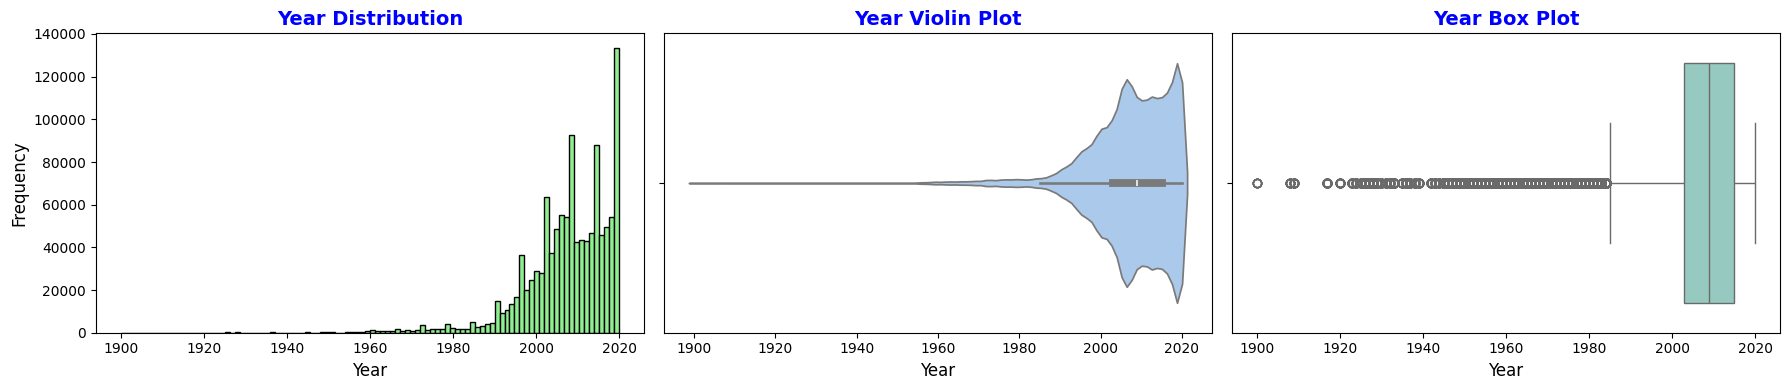

C:\Users\ASUS\AppData\Local\Temp\ipykernel_10424\2224348992.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x=variable, ax=ax, palette='pastel')
C:\Users\ASUS\AppData\Local\Temp\ipykernel_10424\2224348992.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x=variable, ax=ax, palette='Set3')


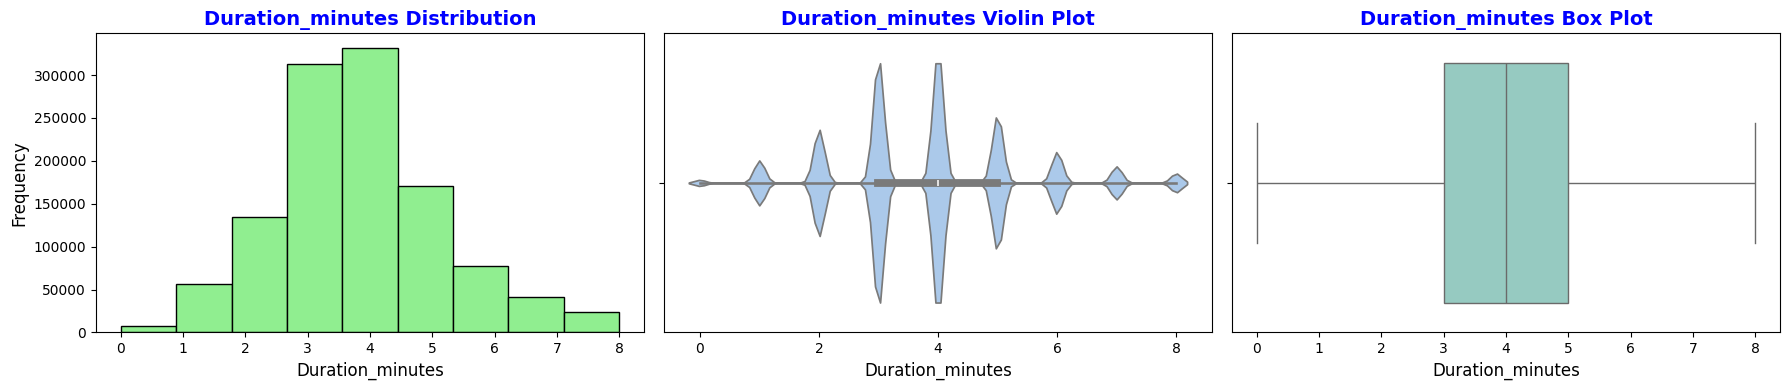

In [58]:
should_do_eda_variables = ["year", "duration_minutes"]
for col in should_do_eda_variables:
    bin_size = spotify_df.select([col]).distinct().count()
    visualize_numeric_variable(spotify_df, col, bin_size)

#### Correlation

<Figure size 1000x800 with 0 Axes>

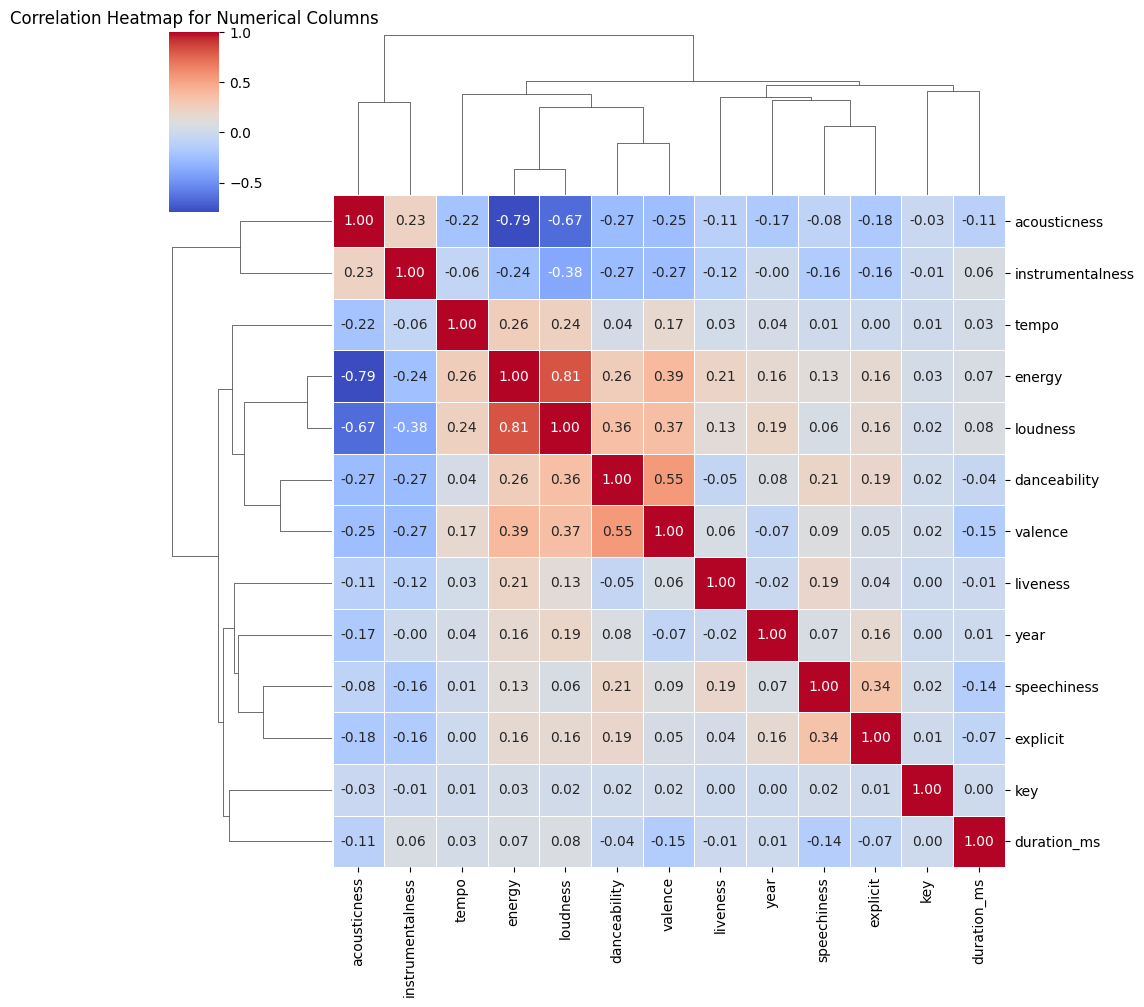

In [61]:
numerical_columns = ["danceability", "energy","key", "loudness", "speechiness", "acousticness", "instrumentalness", "valence", "tempo", "year", "liveness", "duration_ms", "explicit"]
filtered_df = spotify_df.select(*numerical_columns)

pandas_df = filtered_df.toPandas()
correlation_matrix = pandas_df.corr()

plt.figure(figsize=(10, 8))
sns.clustermap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap for Numerical Columns")
plt.show()

as we can see there are high correlation between (energy, loudness) and (dancability, valence) and (energy, acousticness) and (acousticness, loudness). In order to see if they really have a high correlation or not, we have to draw their pairplot.

### Exploring Top-K Records

In [64]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, desc, explode, max, min, split
import matplotlib.pyplot as plt
import plotly.express as px
from pyspark.sql.functions import array_contains
from pyspark.sql.functions import explode

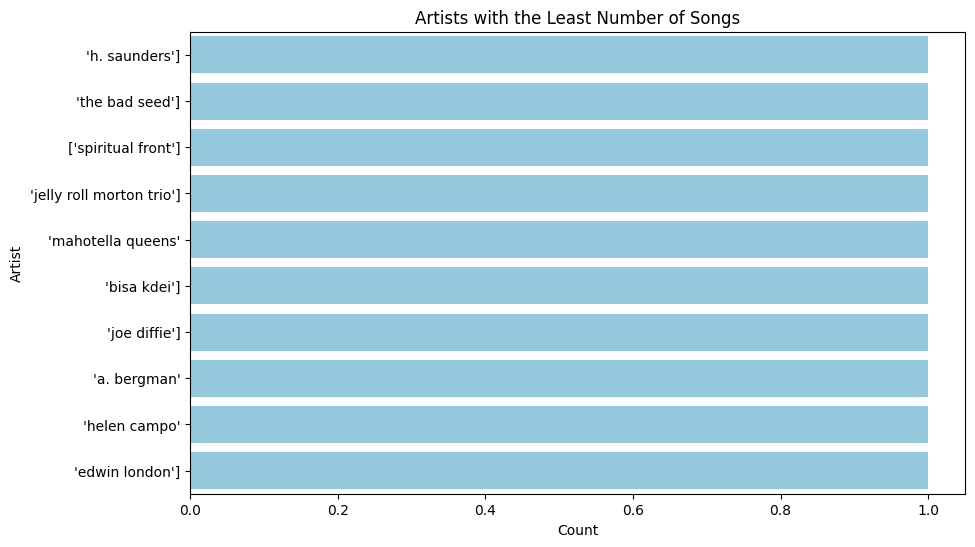

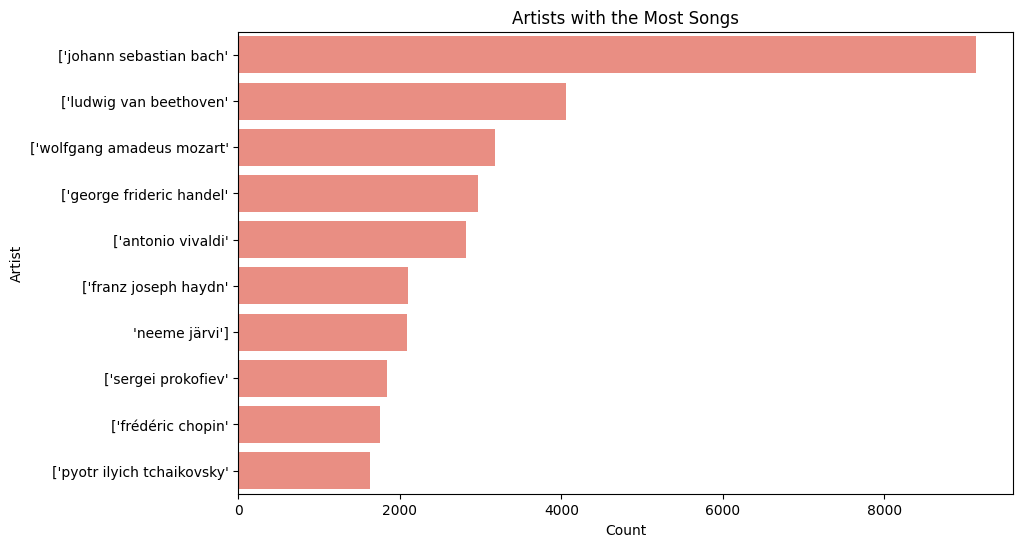

In [31]:
explode_df = df.withColumn("artist", explode(split(col("artists"), ", ")))
artist_counts = explode_df.groupBy("artist").count()
artist_counts = artist_counts.orderBy(col("count").asc())
result_df_least = artist_counts.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='artist', data=result_df_least, color='skyblue')
plt.xlabel('Count')
plt.ylabel('Artist')
plt.title('Artists with the Least Number of Songs')
plt.show()

explode_df = df.withColumn("artist", explode(split(col("artists"), ", ")))
artist_counts = explode_df.groupBy("artist").count()
artist_counts = artist_counts.orderBy(col("count").desc())
result_df_most = artist_counts.limit(10).toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='artist', data=result_df_most, color='salmon')
plt.xlabel('Count')
plt.ylabel('Artist')
plt.title('Artists with the Most Songs')
plt.show()


The most prolific artists are the artists of wordless music.

In [72]:
def find_top_for_characteristic(characteristic):
    df_characteristic = df.select("artists", characteristic)
    df_characteristic = df_characteristic.withColumn("artist", explode(split(col("artists"), ", ")))
    artist_characteristic_avg = df_characteristic.groupBy("artist").avg(characteristic)
    artist_characteristic_avg_desc = artist_characteristic_avg.orderBy(col(f"avg({characteristic})").desc())
    top_artists_characteristic_desc = artist_characteristic_avg_desc.limit(20)
    top_artists_characteristic_df_desc = top_artists_characteristic_desc.toPandas()

    artist_characteristic_avg_asc = artist_characteristic_avg.orderBy(col(f"avg({characteristic})").asc())
    top_artists_characteristic_asc = artist_characteristic_avg_asc.limit(20)
    top_artists_characteristic_df_asc = top_artists_characteristic_asc.toPandas()

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    sns.barplot(x=f'avg({characteristic})', y='artist', data=top_artists_characteristic_df_desc, color='skyblue', ax=axs[0])
    axs[0].set_xlabel(f'Average {characteristic}')
    axs[0].set_ylabel('Artist')
    axs[0].set_title(f'Top Artists - {characteristic.capitalize()} (Descending)')

    sns.barplot(x=f'avg({characteristic})', y='artist', data=top_artists_characteristic_df_asc, color='salmon', ax=axs[1])
    axs[1].set_xlabel(f'Average {characteristic}')
    axs[1].set_ylabel('Artist')
    axs[1].set_title(f'Top Artists - {characteristic.capitalize()} (Ascending)')

    plt.tight_layout()
    plt.show()


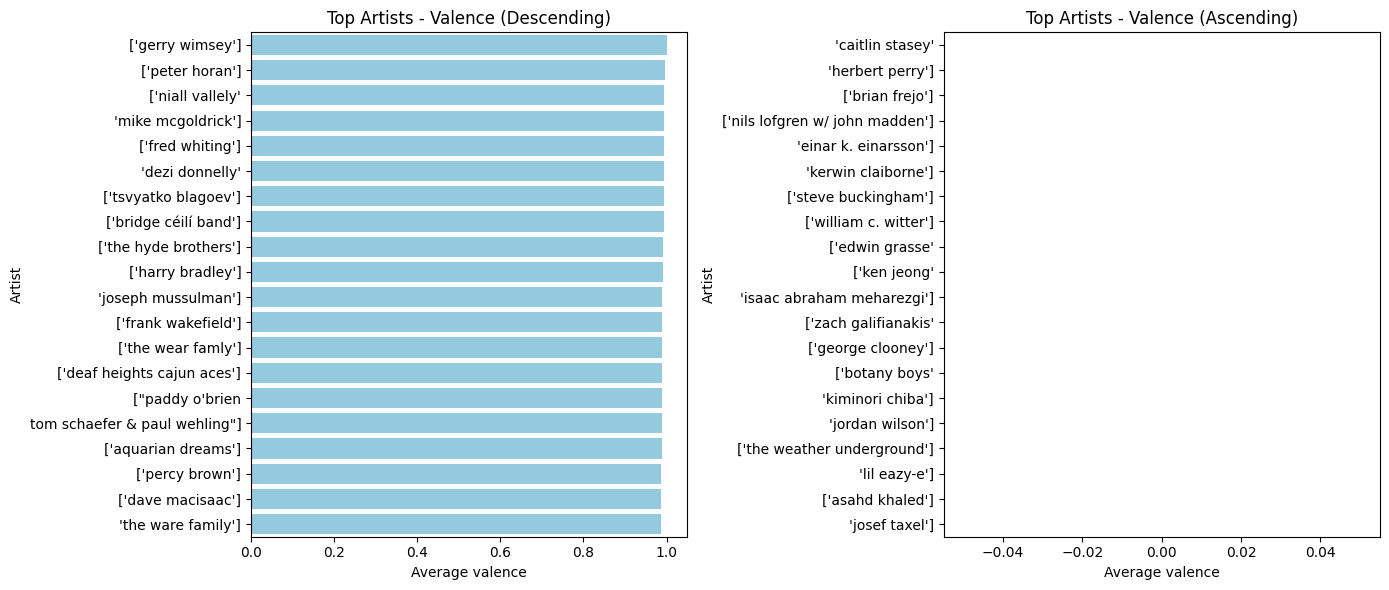

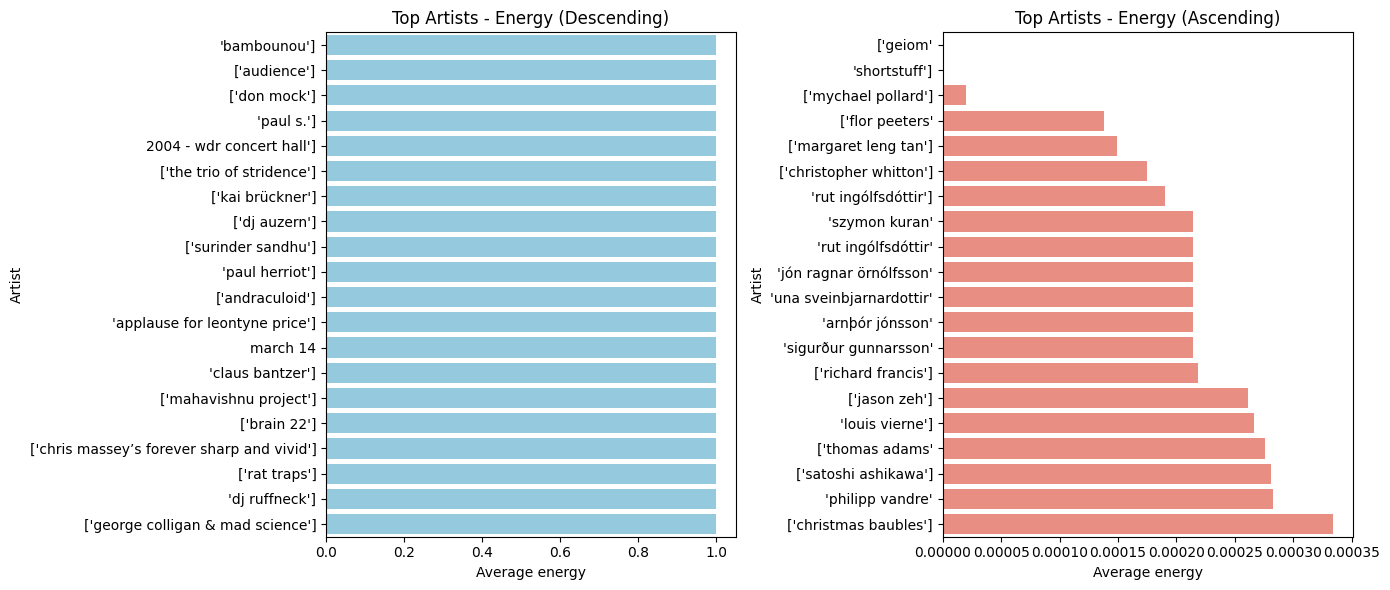

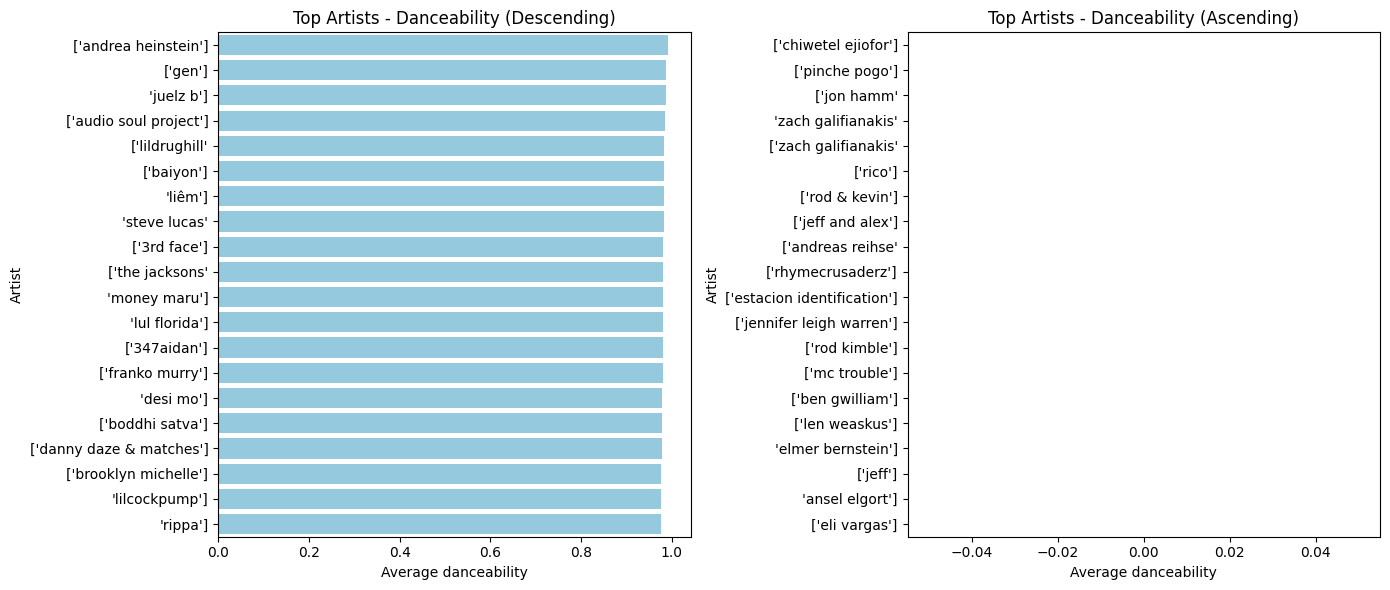

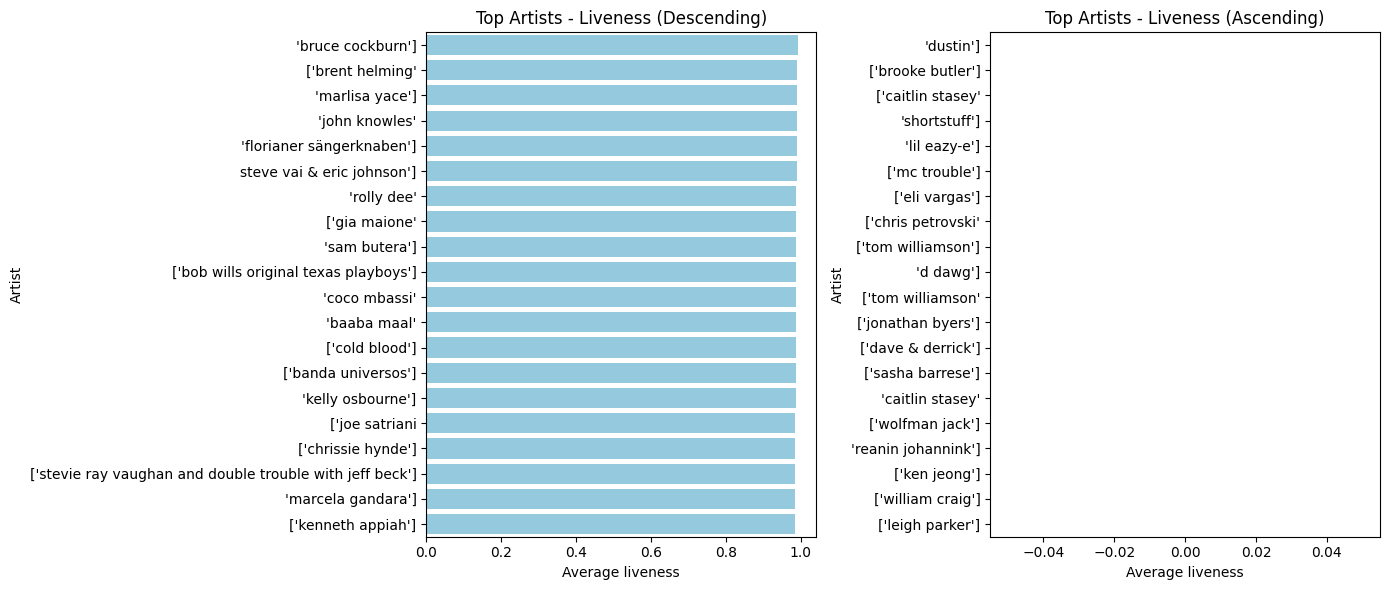

In [73]:
characteristics = ["valence", "energy", "danceability", "liveness"]

for characteristic in characteristics:
    find_top_for_characteristic(characteristic)


# Questions

### 1. Read about how Spark and Hadoop work. What does the term ‘lazy evaluation’ mean for them? Explain with a simple example.

**Hadoop** is a distributed storage and processing framework that stores and processes large datasets across clusters of computers using a simple programming model called MapReduce. It consists of two main components: Hadoop Distributed File System (HDFS) for storage and MapReduce for processing.<br>
**Spark** is an open-source, distributed computing system that provides an interface for programming entire clusters with implicit data parallelism and fault tolerance. It offers in-memory processing for high performance and supports a wide range of workloads like batch processing, interactive queries, streaming, machine learning, and graph processing.<br>
**Lazy evaluation** is a technique used in Spark and Hadoop to optimize data processing by delaying the evaluation of expressions until their results are actually needed. This helps in optimizing performance by reducing unnecessary computations and optimizing the execution plan.<br>
In Spark, transformations (like map, filter, groupBy, etc.) are lazily evaluated. When you apply a transformation on a DataFrame or RDD, Spark does not immediately execute it. It builds up a Directed Acyclic Graph (DAG) of the transformations applied, and the actual computation is triggered only when an action (like show, collect, save, etc.) is called. <br><br><br>

### 2. Your main task’s dataset has about 1,200,000 rows, which makes it quite hard, and even sometimes impossible, to work with. Explain how parquet files try to solve this problem, compared to normal file formats like csv.

**Parquet File Format:**
- Columnar Storage: Parquet is a columnar storage file format, which means that data is stored column by column rather than row by row. This allows for efficient data compression and encoding techniques to be applied, reducing the overall storage space required.
- Predicate Pushdown: Parquet files support predicate pushdown, which means that when querying data, only the relevant columns are read from disk, reducing I/O operations and improving query performance.
Schema Evolution: Parquet files store schema information along with the data, enabling schema evolution without the need to rewrite the entire dataset.
- Partitioning: Parquet files can be partitioned based on one or more columns, enabling data pruning during query execution and improving query performance.

**CSV File Format:**
- Row-based Storage: CSV files store data row by row, which can lead to inefficiencies when processing large datasets. Reading and writing CSV files can be slower compared to columnar formats like Parquet.
No Built-in Compression: CSV files do not have built-in compression, leading to larger file sizes and increased storage requirements.
- Limited Data Types: CSV files have limited support for complex data types, which can be a limitation when working with structured or nested data. <br><br><br>

### 3. As you might have noticed, Spark doesn’t save checkpoints. How can we enforce it to do so? This can help us if we have multiple computation steps and we don’t want to wait a lot for the result.

To enable checkpointing in Spark, you can use the **checkpoint** method on a DataFrame or RDD to save the intermediate results to a reliable storage system like HDFS or S3. This can be helpful when you have multiple computation steps and want to avoid recomputing from scratch in case of failures. <br><br><br>

### 4. Top companies stream their data on a regular routine, e.g. daily. How can we save data, so that we could filter it based on specific columns, e.g. date, faster than regular filtering?

**Partitioning by Date:** 

When storing the streaming data, partition the data by date. This involves organizing the data into directories or files based on the date. For example, you can save data for each day in a separate partition.
Partitioning by date allows for efficient data pruning and filtering based on the date column. When querying the data, the query engine can skip partitions that do not contain the relevant date range, improving query performance.

**Using Parquet File Format:**

Save the streaming data in the Parquet file format. Parquet is a columnar storage format that supports efficient compression and encoding techniques, leading to smaller file sizes and faster query performance.
Parquet files store data column by column, enabling predicate pushdown and faster filtering based on specific columns like date.

**Utilizing Indexing:**

Consider creating indexes on the date column or any other column frequently used for filtering. Indexing can speed up data retrieval by allowing the query engine to quickly locate the relevant data based on the indexed column.
While traditional indexing may not be directly applicable to big data systems, some systems like Apache Hudi support indexing capabilities for faster data access.

**Caching and Materialized Views:**

Cache the frequently accessed data or create materialized views that precompute and store aggregated data based on specific columns like date. This can reduce the computation required for filtering and improve query performance.
In Spark Streaming, you can leverage in-memory caching or persistent storage to store intermediate results for faster access during filtering operations.

**Optimizing Data Storage and Retrieval:**

Optimize the storage layer by using distributed file systems like HDFS or cloud storage solutions that provide scalability and fault tolerance.
Use efficient data serialization formats and compression techniques to reduce storage space and improve data retrieval speed. <br><br><br>

### 5. Let's face off Pandas and PySpark in the data analysis arena! When does each library truly shine, and why? Consider factors like data size, processing complexity, and user experience.

**Pandas:**
- Data Size: For medium-sized datasets that can fit into memory (up to a few gigabytes).
- Processing Complexity: Ideal for data cleaning, manipulation, exploratory data analysis, and small to medium-scale data processing tasks.
- User Experience: Provides a user-friendly interface and is well-suited for interactive data analysis and prototyping.

**PySpark:**
- Data Size: Best suited for processing large-scale datasets that require distributed computing (terabytes or petabytes of data).
- Processing Complexity: Excels in handling complex data transformations, machine learning tasks, and big data processing pipelines.
- User Experience: Offers scalability, fault tolerance, and parallel processing capabilities for handling massive datasets efficiently, but may require more expertise to optimize performance.